In [1]:
from concurrent.futures import ThreadPoolExecutor
import time
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
import json
import re
# from pygments import highlight
# from pygments.lexers import JsonLexer
# from pygments.formatters import HtmlFormatter
# from IPython.display import HTML
import pandas as pd
# from langchain.chat_models import ChatOpenAI
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain.schema import AIMessage, HumanMessage, SystemMessage
from openai import OpenAI
from typing import List, Tuple, Union, Dict, Any
import ast
from rapidfuzz import fuzz, process
import re
import json
import glob
import os
from config import settings

pd.set_option('display.max_colwidth', 500)

llm_api_key = settings.API_CONFIG.llm_api_key
llm_api_url = settings.API_CONFIG.llm_api_url
client = OpenAI(
    api_key = llm_api_key,
    base_url = llm_api_url
)
# from langchain.chat_models import ChatOpenAI
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain.schema import AIMessage, HumanMessage, SystemMessage

llm_gem3 = ChatOpenAI(
        temperature=0,
        openai_api_key=llm_api_key,
        openai_api_base=llm_api_url,
        model=settings.ModelConfig.gemma_model,
        max_tokens=settings.ModelConfig.llm_max_tokens
        )

llm_chat = ChatOpenAI(
        temperature=0,
        model="gpt-4.1",
        openai_api_key=settings.API_CONFIG.openai_api_key,
        max_tokens=2000,
)
llm_cld40 = ChatAnthropic(
    api_key=settings.API_CONFIG.anthropic_api_key,
    model=settings.ModelConfig.claude_model,
    max_tokens=3000
)

In [2]:
from typing import List, Tuple, Union, Dict, Any
import ast

import re
import json
import glob

def dataframe_to_markdown_prompt(df, max_rows=None):
    # Limit rows if needed
    if max_rows is not None and len(df) > max_rows:
        display_df = df.head(max_rows)
        truncation_note = f"\n[Note: Only showing first {max_rows} of {len(df)} rows]"
    else:
        display_df = df
        truncation_note = ""
    
    # Convert to markdown
    df_markdown = display_df.to_markdown()
    
    prompt = f"""

    {df_markdown}
    {truncation_note}

    """
    
    return prompt

def replace_strings(text, replacements):
    for old, new in replacements.items():
        text = text.replace(old, new)
        
    return text

def clean_segment(segment):
    """
    Given a segment that is expected to be quoted (i.e. begins and ends with
    the same single or double quote), remove any occurrences of that quote
    from the inner content.
    For example, if segment is:
         "에이닷 T 멤버십 쿠폰함에 "에이닷은통화요약된닷" 입력"
    then the outer quotes are preserved but the inner double quotes are removed.
    """
    segment = segment.strip()
    if len(segment) >= 2 and segment[0] in ['"', "'"] and segment[-1] == segment[0]:
        q = segment[0]
        # Remove inner occurrences of the quote character.
        inner = segment[1:-1].replace(q, '')
        return q + inner + q
    return segment

def split_key_value(text):
    """
    Splits text into key and value based on the first colon that appears
    outside any quoted region.
    If no colon is found outside quotes, the value will be returned empty.
    """
    in_quote = False
    quote_char = ''
    for i, char in enumerate(text):
        if char in ['"', "'"]:
            # Toggle quote state (assumes well-formed starting/ending quotes for each token)
            if in_quote:
                if char == quote_char:
                    in_quote = False
                    quote_char = ''
            else:
                in_quote = True
                quote_char = char
        elif char == ':' and not in_quote:
            return text[:i], text[i+1:]
    return text, ''

def split_outside_quotes(text, delimiter=','):
    """
    Splits the input text on the given delimiter (default comma) but only
    if the delimiter occurs outside of quoted segments.
    Returns a list of parts.
    """
    parts = []
    current = []
    in_quote = False
    quote_char = ''
    for char in text:
        if char in ['"', "'"]:
            # When encountering a quote, toggle our state
            if in_quote:
                if char == quote_char:
                    in_quote = False
                    quote_char = ''
            else:
                in_quote = True
                quote_char = char
            current.append(char)
        elif char == delimiter and not in_quote:
            parts.append(''.join(current).strip())
            current = []
        else:
            current.append(char)
    if current:
        parts.append(''.join(current).strip())
    return parts

def clean_ill_structured_json(text):
    """
    Given a string that is intended to represent a JSON-like structure
    but may be ill-formed (for example, it might contain nested quotes that
    break standard JSON rules), attempt to “clean” it by processing each
    key–value pair.
    
    The function uses the following heuristics:
      1. Split the input text into comma-separated parts (only splitting
         when the comma is not inside a quoted string).
      2. For each part, split on the first colon (that is outside quotes) to separate key and value.
      3. For any segment that begins and ends with a quote, remove any inner occurrences
         of that same quote.
      4. Rejoin the cleaned key and value.
    
    Note: This approach does not build a fully robust JSON parser. For very complex
          or deeply nested ill-structured inputs further refinement would be needed.
    """
    # First, split the text by commas outside of quotes.
    parts = split_outside_quotes(text, delimiter=',')
    
    cleaned_parts = []
    for part in parts:
        # Try to split into key and value on the first colon not inside quotes.
        key, value = split_key_value(part)
        key_clean = clean_segment(key)
        value_clean = clean_segment(value) if value.strip() != "" else ""
        if value_clean:
            cleaned_parts.append(f"{key_clean}: {value_clean}")
        else:
            cleaned_parts.append(key_clean)
    
    # Rejoin the cleaned parts with commas (or you can use another format if desired)
    return ', '.join(cleaned_parts)

def repair_json(broken_json):
    """
    More advanced JSON repair that handles edge cases better
    """
    json_str = broken_json
    
    # Fix unquoted keys
    json_str = re.sub(r'([{,])\s*([a-zA-Z0-9_]+)\s*:', r'\1 "\2":', json_str)
    
    # Fix unquoted values more carefully
    # Split on quotes to avoid modifying content inside strings
    parts = json_str.split('"')
    
    for i in range(0, len(parts), 2):  # Only process parts outside quotes (even indices)
        # Fix unquoted values in this part
        parts[i] = re.sub(r':\s*([a-zA-Z0-9_]+)(?=\s*[,\]\}])', r': "\1"', parts[i])
    
    json_str = '"'.join(parts)
    
    # Fix trailing commas
    json_str = re.sub(r',\s*([}\]])', r'\1', json_str)
    
    return json_str

def extract_json_objects(text):
    # More sophisticated pattern that tries to match proper JSON syntax
    pattern = r'(\{(?:[^{}]|(?:\{(?:[^{}]|(?:\{[^{}]*\}))*\}))*\})'
    
    result = []
    for match in re.finditer(pattern, text):
        potential_json = match.group(0)
        try:
            # Try to parse and validate
            # json_obj = json.loads(repair_json(potential_json))
            json_obj = ast.literal_eval(clean_ill_structured_json(repair_json(potential_json)))
            result.append(json_obj)
        except json.JSONDecodeError:
            # Not valid JSON, skip
            pass
    
    return result

def extract_between(text, start_marker, end_marker):
    start_index = text.find(start_marker)
    if start_index == -1:
        return None
    
    start_index += len(start_marker)
    end_index = text.find(end_marker, start_index)
    if end_index == -1:
        return None
    
    return text[start_index:end_index]

def extract_content(text: str, tag_name: str) -> List[str]:
    pattern = f'<{tag_name}>(.*?)</{tag_name}>'
    matches = re.findall(pattern, text, re.DOTALL)
    return matches

def clean_bad_text(text):
    import re
    
    if not isinstance(text, str):
        return ""
    
    # Remove URLs and emails
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    
    # Keep Korean, alphanumeric, spaces, and specific punctuation
    text = re.sub(r'[^\uAC00-\uD7A3\u1100-\u11FF\w\s\.\?!,]', ' ', text)
    
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def clean_text(text):
    """
    Cleans text by removing special characters that don't affect fine-tuning.
    Preserves important structural elements like quotes, brackets, and JSON syntax.
    Specifically handles Korean text (Hangul) properly.
    
    Args:
        text (str): The input text to clean
        
    Returns:
        str: Cleaned text ready for fine-tuning
    """
    import re
    
    # Preserve the basic structure by temporarily replacing important characters
    # with placeholder tokens that won't be affected by cleanup
    
    # Step 1: Temporarily replace JSON structural elements
    placeholders = {
        '"': "DQUOTE_TOKEN",
        "'": "SQUOTE_TOKEN",
        "{": "OCURLY_TOKEN",
        "}": "CCURLY_TOKEN",
        "[": "OSQUARE_TOKEN",
        "]": "CSQUARE_TOKEN",
        ":": "COLON_TOKEN",
        ",": "COMMA_TOKEN"
    }
    
    for char, placeholder in placeholders.items():
        text = text.replace(char, placeholder)
    
    # Step 2: Remove problematic characters
    
    # Remove control characters (except newlines, carriage returns, and tabs which can be meaningful)
    text = re.sub(r'[\x00-\x08\x0B\x0C\x0E-\x1F\x7F]', '', text)
    
    # Normalize all types of newlines to \n
    text = re.sub(r'\r\n|\r', '\n', text)
    
    # Remove zero-width characters and other invisible unicode
    text = re.sub(r'[\u200B-\u200D\uFEFF\u00A0]', '', text)
    
    # MODIFIED: Keep Korean characters (Hangul) along with other useful character sets
    # This regex keeps:
    # - ASCII (Basic Latin): \x00-\x7F
    # - Latin-1 Supplement: \u0080-\u00FF
    # - Latin Extended A & B: \u0100-\u017F\u0180-\u024F
    # - Greek and Coptic: \u0370-\u03FF
    # - Cyrillic: \u0400-\u04FF
    # - Korean Hangul Syllables: \uAC00-\uD7A3
    # - Hangul Jamo (Korean alphabet): \u1100-\u11FF
    # - Hangul Jamo Extended-A: \u3130-\u318F
    # - Hangul Jamo Extended-B: \uA960-\uA97F
    # - Hangul Compatibility Jamo: \u3130-\u318F
    # - CJK symbols and punctuation: \u3000-\u303F
    # - Full-width forms (often used with CJK): \uFF00-\uFFEF
    # - CJK Unified Ideographs (Basic common Chinese/Japanese characters): \u4E00-\u9FFF
    
    # Instead of removing characters, we'll define which ones to keep
    allowed_chars_pattern = r'[^\x00-\x7F\u0080-\u00FF\u0100-\u024F\u0370-\u03FF\u0400-\u04FF' + \
                           r'\u1100-\u11FF\u3130-\u318F\uA960-\uA97F\u3000-\u303F' + \
                           r'\uAC00-\uD7A3\uFF00-\uFFEF\u4E00-\u9FFF\n\r\t ]'
    text = re.sub(allowed_chars_pattern, '', text)
    
    # Step 3: Normalize whitespace (but preserve deliberate line breaks)
    text = re.sub(r'[ \t]+', ' ', text)  # Convert multiple spaces/tabs to single space
    
    # First ensure all newlines are standardized
    text = re.sub(r'\r\n|\r', '\n', text)  # Convert all newline variants to \n
    
    # Then normalize multiple blank lines to at most two
    text = re.sub(r'\n\s*\n+', '\n\n', text)  # Convert multiple newlines to at most two
    
    # Step 4: Restore original JSON structural elements
    for char, placeholder in placeholders.items():
        text = text.replace(placeholder, char)
    
    # Step 5: Fix common JSON syntax issues that might remain
    # Fix spaces between quotes and colons in JSON
    text = re.sub(r'"\s+:', r'":', text)
    
    # Fix trailing commas in arrays
    text = re.sub(r',\s*]', r']', text)
    
    # Fix trailing commas in objects
    text = re.sub(r',\s*}', r'}', text)
    
    return text

def remove_control_characters(text):
    if isinstance(text, str):
        # Remove control characters except commonly used whitespace
        return re.sub(r'[\x00-\x08\x0B-\x0C\x0E-\x1F\x7F]', '', text)
    return text

import openai
from langchain.chains import RetrievalQA
from langchain.llms.openai import OpenAIChat  # For compatibility with newer setup

# Create a custom LLM class that uses the OpenAI client directly
class CustomOpenAI:
    def __init__(self, model="skt/gemma3-12b-it"):
        self.model = model
        
    def __call__(self, prompt):
        response = client.chat.completions.create(
            model=self.model,
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.1
        )
        return response.choices[0].message.content

# Create a simple retrieval function
def get_relevant_context(query, vectorstore, topk=5):
    docs = vectorstore.similarity_search(query, k=topk)
    context = "\n\n".join([doc.page_content for doc in docs])
    titles = ", ".join(set([doc.metadata['title'] for doc in docs if 'title' in doc.metadata.keys()]))
    return {'title':titles, 'context':context}

# Create a function to combine everything
def answer_question(query, vectorstore):
    # Get relevant context
    context = get_relevant_context(query, vectorstore)
    
    # Create combined prompt
    prompt = f"Answer the following question based on the provided context:\n\nContext: {context}\n\nQuestion: {query}\n\nAnswer:"
    
    # Use OpenAI directly
    custom_llm = CustomOpenAI()  # Or your preferred model
    response = custom_llm(prompt)
    
    return response

def is_list_of_dicts(var):
    # Check if the variable is a list
    if not isinstance(var, list):
        return False
    
    # Check if the list is not empty and all elements are dictionaries
    if not var:  # Empty list
        return False
        
    # Check that all elements are dictionaries
    return all(isinstance(item, dict) for item in var)

def remove_duplicate_dicts(dict_list):
    result = []
    seen = set()
    for d in dict_list:
        # Convert dictionary to a hashable tuple of items
        t = tuple(sorted(d.items()))
        if t not in seen:
            seen.add(t)
            result.append(d)
    return result

def convert_to_custom_format(json_items):
    custom_format = []
    
    for item in json_items:
        item_name = item.get("item_name_in_message", "")
        item_id = item.get("item_id", "")
        category = item.get("category", "")
        
        # Create custom format for each item
        custom_line = f"[Item Name] {item_name} [Item ID] {item_id} [Item Category] {category}"
        custom_format.append(custom_line)
    
    return "\n".join(custom_format)

def remove_urls(text):
    # Regular expression pattern to match URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    
    # Replace URLs with an empty string
    return url_pattern.sub('', text)

def remove_custom_pattern(text, keyword="바로가기"):
    # Create a pattern that matches any text followed by the specified keyword
    # We escape the keyword to handle any special regex characters it might contain
    escaped_keyword = re.escape(keyword)
    pattern = re.compile(r'.*? ' + escaped_keyword)
    
    # Replace the matched pattern with an empty string
    return pattern.sub('', text)

def select_most_comprehensive(strings):
    """
    Select the most comprehensive string from a list of overlapping strings.
    Returns the longest string that contains other strings as substrings.
    
    Args:
        strings: List of strings to filter
        
    Returns:
        List of most comprehensive strings (usually one, but could be multiple if no containment)
    """
    if not strings:
        return []
    
    # Remove duplicates and sort by length (longest first)
    unique_strings = list(set(strings))
    unique_strings.sort(key=len, reverse=True)
    
    result = []
    
    for current in unique_strings:
        # Check if current string contains any of the strings already in result
        is_contained = any(current in existing for existing in result)
        
        # Check if current string contains other strings not yet in result
        contains_others = any(other in current for other in unique_strings if other != current and other not in result)
        
        # If current is not contained by existing results and either:
        # 1. It contains other strings, or 
        # 2. No strings contain each other (keep all unique)
        if not is_contained:
            # Remove any strings from result that are contained in current
            result = [r for r in result if r not in current]
            result.append(current)
    
    return result

def replace_special_chars_comprehensive(text):
    """
    More comprehensive: Handle various types of special characters.
    """
    # Replace common punctuation with space
    punctuation_pattern = r'[!@#$%^&*()_+\-=\[\]{};\':"\\|,.<>?/~`]'
    text = re.sub(punctuation_pattern, ' ', text)
    
    # Replace other special symbols
    symbol_pattern = r'[₩＄￦※◆▲▼◀▶★☆♪♫♬♩♭♯]'
    text = re.sub(symbol_pattern, ' ', text)
    
    # Replace various dashes and quotes
    dash_quote_pattern = r'[—–‒―""''‚„‹›«»]'
    text = re.sub(dash_quote_pattern, ' ', text)
    
    # Clean up multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def preprocess_text(text):
    # 특수문자를 공백으로 변환
    text = re.sub(r'[^\w\s]', ' ', text)
    # 여러 공백을 하나로 통일
    text = re.sub(r'\s+', ' ', text)
    # 앞뒤 공백 제거
    return text.strip()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from difflib import SequenceMatcher
def advanced_sequential_similarity(str1, str2, metrics=None, visualize=False):
    """
    Calculate multiple character-level similarity metrics between two strings.
    Parameters:
    -----------
    str1 : str
        First string
    str2 : str
        Second string
    metrics : list
        List of metrics to compute. Options:
        ['ngram', 'lcs', 'subsequence', 'difflib']
        If None, all metrics will be computed
    visualize : bool
        If True, visualize the differences between strings
    Returns:
    --------
    dict
        Dictionary containing similarity scores for each metric
    """
    if metrics is None:
        metrics = ['ngram', 'lcs', 'subsequence', 'difflib']
    results = {}
    # Handle empty strings
    if not str1 or not str2:
        return {metric: 0.0 for metric in metrics+['overall']}
    # Prepare strings
    s1, s2 = str1.lower(), str2.lower()
    # 1. N-gram similarity (with multiple window sizes)
    if 'ngram' in metrics:
        ngram_scores = {}
        for window in range(min([len(s1),len(s2),2]), min([5,max([len(s1),len(s2)])+1])):
            # Skip if strings are shorter than window
            if len(s1) < window or len(s2) < window:
                ngram_scores[f'window_{window}'] = 0.0
                continue
            # Generate character n-grams
            ngrams1 = [s1[i:i+window] for i in range(len(s1) - window + 1)]
            ngrams2 = [s2[i:i+window] for i in range(len(s2) - window + 1)]
            # Count matches
            matches = sum(1 for ng in ngrams1 if ng in ngrams2)
            max_possible = max(len(ngrams1), len(ngrams2))
            # Normalize
            score = matches / max_possible if max_possible > 0 else 0.0
            ngram_scores[f'window_{window}'] = score
        # Average of all n-gram scores
        results['ngram'] = max(ngram_scores.values())#sum(ngram_scores.values()) / len(ngram_scores)
        results['ngram_details'] = ngram_scores
    # 2. Longest Common Substring (LCS)
    if 'lcs' in metrics:
        def longest_common_substring(s1, s2):
            # Dynamic programming approach
            m, n = len(s1), len(s2)
            dp = [[0] * (n + 1) for _ in range(m + 1)]
            max_length = 0
            for i in range(1, m + 1):
                for j in range(1, n + 1):
                    if s1[i-1] == s2[j-1]:
                        dp[i][j] = dp[i-1][j-1] + 1
                        max_length = max(max_length, dp[i][j])
            return max_length
        lcs_length = longest_common_substring(s1, s2)
        max_length = max(len(s1), len(s2))
        results['lcs'] = lcs_length / max_length if max_length > 0 else 0.0
    # 3. Longest Common Subsequence
    if 'subsequence' in metrics:
        def longest_common_subsequence(s1, s2):
            # Dynamic programming approach for subsequence
            m, n = len(s1), len(s2)
            dp = [[0] * (n + 1) for _ in range(m + 1)]
            for i in range(1, m + 1):
                for j in range(1, n + 1):
                    if s1[i-1] == s2[j-1]:
                        dp[i][j] = dp[i-1][j-1] + 1
                    else:
                        dp[i][j] = max(dp[i-1][j], dp[i][j-1])
            return dp[m][n]
        subseq_length = longest_common_subsequence(s1, s2)
        max_length = max(len(s1), len(s2))
        results['subsequence'] = subseq_length / max_length if max_length > 0 else 0.0
    # 4. SequenceMatcher from difflib
    if 'difflib' in metrics:
        sm = SequenceMatcher(None, s1, s2)
        results['difflib'] = sm.ratio()
    # Visualization of differences
    if visualize:
        try:
            # Only works in notebooks or environments that support plotting
            sm = SequenceMatcher(None, s1, s2)
            matches = sm.get_matching_blocks()
            # Prepare for visualization
            fig, ax = plt.subplots(figsize=(10, 3))
            # Draw strings as horizontal bars
            ax.barh(0, len(s1), height=0.4, left=0, color='lightgray', alpha=0.3)
            ax.barh(1, len(s2), height=0.4, left=0, color='lightgray', alpha=0.3)
            # Draw matching parts
            for match in matches:
                i, j, size = match
                if size > 0:  # Ignore zero-length matches
                    ax.barh(0, size, height=0.4, left=i, color='green', alpha=0.5)
                    ax.barh(1, size, height=0.4, left=j, color='green', alpha=0.5)
                    # Draw connection lines between matches
                    ax.plot([i + size/2, j + size/2], [0.2, 0.8], 'k-', alpha=0.3)
            # Add string texts
            for i, c in enumerate(s1):
                ax.text(i + 0.5, 0, c, ha='center', va='center')
            for i, c in enumerate(s2):
                ax.text(i + 0.5, 1, c, ha='center', va='center')
            ax.set_yticks([0, 1])
            ax.set_yticklabels(['String 1', 'String 2'])
            ax.set_xlabel('Character Position')
            ax.set_title('Character-Level String Comparison')
            ax.grid(False)
            plt.tight_layout()
            # plt.show()  # Uncomment to display
        except Exception as e:
            print(f"Visualization error: {e}")
    # Calculate overall similarity score (average of all metrics)
    metrics_to_average = [m for m in results.keys() if not m.endswith('_details')]
    results['overall'] = sum(results[m] for m in metrics_to_average) / len(metrics_to_average)
    return results
# advanced_sequential_similarity('시크릿', '시크릿', metrics='ngram')
# advanced_sequential_similarity('에이닷_자사', '에이닷')['overall']

In [4]:
import difflib
from difflib import SequenceMatcher
import re

def longest_common_subsequence_ratio(s1, s2, normalizaton_value):
    """
    Calculate similarity based on longest common subsequence (LCS).
    Preserves order and gives high scores for substring relationships.
    """
    def lcs_length(x, y):
        m, n = len(x), len(y)
        dp = [[0] * (n + 1) for _ in range(m + 1)]
        
        for i in range(1, m + 1):
            for j in range(1, n + 1):
                if x[i-1] == y[j-1]:
                    dp[i][j] = dp[i-1][j-1] + 1
                else:
                    dp[i][j] = max(dp[i-1][j], dp[i][j-1])
        
        return dp[m][n]
    
    lcs_len = lcs_length(s1, s2)
    if normalizaton_value == 'max':
        max_len = max(len(s1), len(s2))
        return lcs_len / max_len if max_len > 0 else 1.0
    elif normalizaton_value == 'min':
        min_len = min(len(s1), len(s2))
        return lcs_len / min_len if min_len > 0 else 1.0
    elif normalizaton_value == 's1':
        return lcs_len / len(s1) if len(s1) > 0 else 1.0
    elif normalizaton_value == 's2':
        return lcs_len / len(s2) if len(s2) > 0 else 1.0
    else:
        raise ValueError(f"Invalid normalization value: {normalizaton_value}")

# def sequence_matcher_similarity(s1, s2):
#     """
#     Use Python's built-in SequenceMatcher which considers sequence order.
#     """
#     return SequenceMatcher(None, s1, s2).ratio()

def sequence_matcher_similarity(s1, s2, normalizaton_value):
    """Normalize by minimum length (favors shorter strings)"""
    matcher = difflib.SequenceMatcher(None, s1, s2)
    matches = sum(triple.size for triple in matcher.get_matching_blocks())

    normalization_length = min(len(s1), len(s2))
    if normalizaton_value == 'max':
        normalization_length = max(len(s1), len(s2))
    elif normalizaton_value == 's1':
        normalization_length = len(s1)
    elif normalizaton_value == 's2':
        normalization_length = len(s2)
        
    if normalization_length == 0: 
        return 0.0
    
    return matches / normalization_length

def substring_aware_similarity(s1, s2, normalizaton_value):
    """
    Custom similarity that heavily weights substring relationships
    while considering sequence order.
    """
    # Check if one is a substring of the other
    if s1 in s2 or s2 in s1:
        shorter = min(s1, s2, key=len)
        longer = max(s1, s2, key=len)
        # High base score for substring relationship
        base_score = len(shorter) / len(longer)
        # Bonus for exact substring match
        return min(0.95 + base_score * 0.05, 1.0)
    
    # Use LCS ratio for non-substring cases
    return longest_common_subsequence_ratio(s1, s2, normalizaton_value)

def token_sequence_similarity(s1, s2, normalizaton_value, separator_pattern=r'[\s_\-]+'):
    """
    Tokenize strings and calculate similarity based on token sequence overlap.
    Good for product names with separators.
    """
    tokens1 = re.split(separator_pattern, s1.strip())
    tokens2 = re.split(separator_pattern, s2.strip())
    
    # Remove empty tokens
    tokens1 = [t for t in tokens1 if t]
    tokens2 = [t for t in tokens2 if t]
    
    if not tokens1 or not tokens2:
        return 0.0
    
    # Find longest common subsequence of tokens
    def token_lcs_length(t1, t2):
        m, n = len(t1), len(t2)
        dp = [[0] * (n + 1) for _ in range(m + 1)]
        
        for i in range(1, m + 1):
            for j in range(1, n + 1):
                if t1[i-1] == t2[j-1]:
                    dp[i][j] = dp[i-1][j-1] + 1
                else:
                    dp[i][j] = max(dp[i-1][j], dp[i][j-1])
        
        return dp[m][n]
    
    lcs_tokens = token_lcs_length(tokens1, tokens2)
    normalization_tokens = max(len(tokens1), len(tokens2))
    if normalizaton_value == 'min':
        normalization_tokens = min(len(tokens1), len(tokens2))
    elif normalizaton_value == 's1':
        normalization_tokens = len(tokens1)
    elif normalizaton_value == 's2':
        normalization_tokens = len(tokens2)
    
    # print(normalizaton_value, normalization_tokens, lcs_tokens)
        
    return lcs_tokens / normalization_tokens  

def combined_sequence_similarity(s1, s2, weights=None, normalizaton_value='max'):
    """
    Combine multiple sequence-aware similarity measures.
    """
    if weights is None:
        weights = {
            'substring': 0.4,
            'sequence_matcher': 0.4,
            'token_sequence': 0.2
        }
    
    similarities = {
        'substring': substring_aware_similarity(s1, s2, normalizaton_value),
        'sequence_matcher': sequence_matcher_similarity(s1, s2, normalizaton_value),
        'token_sequence': token_sequence_similarity(s1, s2, normalizaton_value)
    }
    
    combined = sum(similarities[key] * weights[key] for key in weights)
    return combined, similarities


In [5]:
from joblib import Parallel, delayed

os.environ["TOKENIZERS_PARALLELISM"] = "true"

def fuzzy_similarities(text, entities):
    results = []
    for entity in entities:
        scores = {
            'ratio': fuzz.ratio(text, entity) / 100,
            'partial_ratio': fuzz.partial_ratio(text, entity) / 100,
            'token_sort_ratio': fuzz.token_sort_ratio(text, entity) / 100,
            'token_set_ratio': fuzz.token_set_ratio(text, entity) / 100
        }
        max_score = max(scores.values())
        results.append((entity, max_score))
    return results

def get_fuzzy_similarities(args_dict):
    text = args_dict['text']
    entities = args_dict['entities']
    threshold = args_dict['threshold']
    text_col_nm = args_dict['text_col_nm']
    item_col_nm = args_dict['item_col_nm']

    # Get similarities using auto method selection
    text_processed = preprocess_text(text.lower())
    similarities = fuzzy_similarities(text_processed, entities)
    
    # Filter by threshold and create DataFrame
    filtered_results = [
        {
            text_col_nm: text,
            item_col_nm: entity, 
            "sim": score
        } 
        for entity, score in similarities 
        if score >= threshold
    ]
    
    return filtered_results

def parallel_fuzzy_similarity(texts, entities, threshold=0.5, text_col_nm='sent', item_col_nm='item_nm_alias', n_jobs=None, batch_size=None):
    """
    Batched version for better performance with large datasets.
    """
    if n_jobs is None:
        n_jobs = min(os.cpu_count()-1, 8)  # Limit to 8 jobs max

    if batch_size is None:
        batch_size = max(1, len(entities) // (n_jobs * 2))
        
    # Create batches
    batches = []
    for text in texts:
        for i in range(0, len(entities), batch_size):
            batch = entities[i:i + batch_size]
            batches.append({"text": text, "entities": batch, "threshold": threshold, "text_col_nm": text_col_nm, "item_col_nm": item_col_nm})
    
    # print(f"Processing {len(item_list)} items in {len(batches)|} batches with {n_jobs} jobs...")
    
    # Run parallel jobs
    with Parallel(n_jobs=n_jobs) as parallel:
        batch_results = parallel(delayed(get_fuzzy_similarities)(args) for args in batches)
    
    # # Flatten results
    # similarities = []
    # for batch_result in batch_results:
    #     similarities.extend(batch_result)
    
    return pd.DataFrame(sum(batch_results, []))

def calculate_seq_similarity(args_dict):
    """
    Process a batch of items in one job for better efficiency.
    """
    sent_item_batch = args_dict['sent_item_batch']
    text_col_nm = args_dict['text_col_nm']
    item_col_nm = args_dict['item_col_nm']
    normalizaton_value = args_dict['normalizaton_value']
    
    results = []
    for sent_item in sent_item_batch:
        sent = sent_item[text_col_nm]
        item = sent_item[item_col_nm]
        try:
            sent_processed = preprocess_text(sent.lower())
            item_processed = preprocess_text(item.lower())
            similarity = combined_sequence_similarity(sent_processed, item_processed, normalizaton_value=normalizaton_value)[0]
            results.append({text_col_nm:sent, item_col_nm:item, "sim":similarity})
        except Exception as e:
            print(f"Error processing {item}: {e}")
            results.append({text_col_nm:sent, item_col_nm:item, "sim":0.0})
    
    return results

def parallel_seq_similarity(sent_item_pdf, text_col_nm='sent', item_col_nm='item_nm_alias', n_jobs=None, batch_size=None, normalizaton_value='s2'):
    """
    Batched version for better performance with large datasets.
    """
    if n_jobs is None:
        n_jobs = min(os.cpu_count()-1, 8)  # Limit to 8 jobs max

    if batch_size is None:
        batch_size = max(1, sent_item_pdf.shape[0] // (n_jobs * 2))
        
    # Create batches
    batches = []
    for i in range(0, sent_item_pdf.shape[0], batch_size):
        batch = sent_item_pdf.iloc[i:i + batch_size].to_dict(orient='records')
        batches.append({"sent_item_batch": batch, 'text_col_nm': text_col_nm, 'item_col_nm': item_col_nm, 'normalizaton_value': normalizaton_value})
    
    # print(f"Processing {len(item_list)} items in {len(batches)|} batches with {n_jobs} jobs...")
    
    # Run parallel jobs
    with Parallel(n_jobs=n_jobs) as parallel:
        batch_results = parallel(delayed(calculate_seq_similarity)(args) for args in batches)
    
    # Flatten results
    # similarities = []
    # for batch_result in batch_results:
    #     similarities.extend(batch_result)
    
    return pd.DataFrame(sum(batch_results, []))

In [6]:
import torch
from datetime import datetime
def save_embeddings_numpy(embeddings, texts, filename):
    """
    Save embeddings as NumPy arrays (.npz format).
    Most common and efficient method.
    """
    if torch.is_tensor(embeddings):
        embeddings = embeddings.cpu().numpy()
    np.savez_compressed(
        filename,
        embeddings=embeddings,
        texts=texts,
        timestamp=str(datetime.now())
    )
    print(f"✅ Saved embeddings to {filename}")
def load_embeddings_numpy(filename):
    """Load embeddings from NumPy .npz file."""
    data = np.load(filename, allow_pickle=True)
    embeddings = data['embeddings']
    texts = data['texts']
    timestamp = data['timestamp'] if 'timestamp' in data else None
    print(f"✅ Loaded {len(embeddings)} embeddings from {filename}")
    if timestamp:
        print(f"   Created: {timestamp}")
    return embeddings, texts


In [7]:
import os
from sentence_transformers import SentenceTransformer
import torch
def save_sentence_transformer(model_name, save_path):
    """Download and save SentenceTransformer model locally"""
    print(f"Downloading {model_name}...")
    model = SentenceTransformer(model_name)
    # Create directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)
    # Save the model
    model.save(save_path)
    print(f"Model saved to {save_path}")
    return model
def load_sentence_transformer(model_path, device=None):
    """Load SentenceTransformer model from local path"""
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Loading model from {model_path}...")
    model = SentenceTransformer(model_path).to(device)
    print(f"Model loaded on {device}")
    return model
# Usage
# Save model (do this once)
# model = save_sentence_transformer('jhgan/ko-sbert-nli', './models/ko-sbert-nli')


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from sentence_transformers import SentenceTransformer

def check_mps_availability():
    """Check if MPS is available on this Mac."""
    print(f"PyTorch version: {torch.__version__}")
    print(f"MPS available: {torch.backends.mps.is_available()}")
    print(f"MPS built: {torch.backends.mps.is_built()}")
    
    if torch.backends.mps.is_available():
        print("✅ MPS is available and ready to use!")
        return True
    else:
        print("❌ MPS is not available. Using CPU instead.")
        return False

mps_available = check_mps_availability()
    
# Determine device
if mps_available:
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

# emb_model = SentenceTransformer('jhgan/ko-sbert-nli').to(device)
emb_model = load_sentence_transformer('./models/ko-sbert-nli', device)
# emb_model = SentenceTransformer('jhgan/ko-sroberta-multitask').to(device)


PyTorch version: 2.7.1
MPS available: True
MPS built: True
✅ MPS is available and ready to use!
Loading model from ./models/ko-sbert-nli...
Model loaded on mps


In [9]:
item_pdf_raw = pd.read_csv(settings.METADATA_CONFIG.offer_data_path)

item_pdf_all = item_pdf_raw.drop_duplicates(['item_nm','item_id'])[['item_nm','item_id','item_desc','item_dmn']].copy()
item_pdf_all['item_ctg'] = None
item_pdf_all['item_emb_vec'] = None
item_pdf_all['ofer_cd'] = item_pdf_all['item_id']
item_pdf_all['oper_dt_hms'] = '20250101000000'

item_pdf_all = item_pdf_all.rename(columns={c:c.lower() for c in item_pdf_all.columns})

if settings.PROCESSING_CONFIG.excluded_domain_codes_for_items:
    item_pdf_all = item_pdf_all.query("item_dmn not in @settings.PROCESSING_CONFIG.excluded_domain_codes_for_items")

# item_pdf_all.query("rank<1000")[['item_nm']].drop_duplicates().to_csv("./data/item_nm_1000.csv", index=False)
alias_pdf = pd.read_csv(settings.METADATA_CONFIG.alias_rules_path)
alia_rule_set = list(zip(alias_pdf['alias_1'], alias_pdf['alias_2']))

def apply_alias_rule(item_nm):
    item_nm_list = [item_nm]

    for r in alia_rule_set:
        if r[0] in item_nm:
            item_nm_list.append(item_nm.replace(r[0], r[1]))
        if r[1] in item_nm:
            item_nm_list.append(item_nm.replace(r[1], r[0]))
    return item_nm_list

item_pdf_all['item_nm_alias'] = item_pdf_all['item_nm'].apply(apply_alias_rule)

item_pdf_all = item_pdf_all.explode('item_nm_alias')

user_defined_entity = ['AIA Vitality' , '부스트 파크 건대입구' , 'Boost Park 건대입구']
item_pdf_ext = pd.DataFrame([{'item_nm':e,'item_id':e,'item_desc':e, 'item_dmn':'user_defined', 'start_dt':20250101, 'end_dt':99991231, 'rank':1, 'item_nm_alias':e} for e in user_defined_entity])
item_pdf_all = pd.concat([item_pdf_all,item_pdf_ext])

stop_item_names = pd.read_csv(settings.METADATA_CONFIG.stop_items_path)['stop_words'].to_list()

entity_vocab = []
for row in item_pdf_all.to_dict('records'):
    if row['item_nm_alias'] in stop_item_names:
        continue
    entity_vocab.append((row['item_nm_alias'], {'item_nm':row['item_nm'], 'item_id':row['item_id'], 'description':row['item_desc'], 'item_dmn':row['item_dmn'],'item_nm_alias':row['item_nm_alias']}))

entity_list_for_fuzzy = []
for row in item_pdf_all.to_dict('records'):
    entity_list_for_fuzzy.append((row['item_nm_alias'], {'item_nm':row['item_nm'], 'item_id':row['item_id'], 'description':row['item_desc'], 'item_dmn':row['item_dmn'], 'start_dt':row['start_dt'], 'end_dt':row['end_dt'], 'rank':1, 'item_nm_alias':row['item_nm_alias']}))

# text_list_item = [preprocess_text(x).lower() for x in item_pdf_all['item_nm_alias'].tolist()]
# item_embeddings = emb_model.encode(text_list_item
#                             # ,batch_size=64  # Optimal for MPS
#                             ,convert_to_tensor=True
#                             ,show_progress_bar=True)

# save_embeddings_numpy(item_embeddings, text_list_item, './data/item_embeddings_250527.npz')

In [17]:
mms_pdf = pd.read_csv(settings.METADATA_CONFIG.mms_msg_path)
# mms_pdf['msg'] = mms_pdf['msg_nm']+"\n"+mms_pdf['mms_phrs']
# mms_pdf = mms_pdf.groupby(["msg_nm","mms_phrs","msg"])['offer_dt'].min().reset_index(name="offer_dt")
# mms_pdf = mms_pdf.reset_index()
mms_pdf = mms_pdf.astype('str')
mms_pdf['msg_id'] = mms_pdf.index
mms_pdf['ext_yn'] = 'N'

In [ ]:
# pd.read_csv('./data/batch_results.csv')

mms_pdf = pd.read_csv("./data/mms_data_250408.csv")
mms_pdf = mms_pdf.groupby(["msg_nm","mms_phrs","msg"])['offer_dt'].min().reset_index(name="offer_dt")
mms_pdf['ext_yn'] = 'N'
mms_pdf['msg_id'] = mms_pdf.index
mms_pdf.to_csv("./data/mms_data_250408_ext.csv", index=False)

index                                         msg_nm  \
0          0   (광고)[SKT] ifland에서 유명 안무가와 LIVE 워크샵 겸 팬미팅 안내   
1          1                           0을 위한 최신 아이폰을 만나보세요!   
2          2                      1000만 다운로드 음악앱 FLO 고객 감사제   
3          3                    5GX 프라임만 누릴 수 있는 VR팩 할인 혜택!   
4          4                Boost Park 홍대입구가 드리는 혜택을 받으세요.    
...      ...                                            ...   
23945  23945                 ［SK텔레콤］일상의 디지털 메이트, A.(에이닷) 안내   
23946  23946                 ［SK텔레콤］일상의 디지털 메이트, A.(에이닷) 안내   
23947  23947                 ［SK텔레콤］일상의 디지털 메이트, A.(에이닷) 안내   
23948  23948        ［SK텔레콤］참스타대리점 로데오중앙점 T-Factory오픈 이벤트 안내   
23949  23949           ［SK텔레콤］참스타대리점 센트럴파크점 OPEN 1주년 이벤트 안내   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  mms_phrs  \
0      (광고)[SKT] ifland 아마존 크루 LIVE 팬미팅 안내__#04 고객님, 안녕하세요.__요즘 대세 ‘박혜림’ 안무가의 아마존 댄스 크루와 LIVE로 소통하고 싶다면?_메타버스 컬처 프로젝트의 두 번째 시리즈._1MILLION Dance Studio와 함께하는 다양한 프로그램에 참가해보세요.__5월 25일(수) 오픈 이벤트를 시작으로, 매 주 찾아오는 튜토리얼 클래스까지!_국내 최고 안무가들과 메타버스에서 만나요._ _■ 1MILLION Dance Studio land 오픈 이벤트_- 일시: 5월 25일(수) 저녁 8시_- 출연: 아마존 댄스 크루의 축하 공연 및 LIVE 팬미팅_ _▶ 인스타그램 스토리로 아마존 크루에게 질문하기: https://instagram.com/ifland.official/_▶ 이프랜드(ifland) 앱 구경하기: https://app.ifland.ai/iflandmms_ _■ 문의: SKT고객센터(1558, 무료)_ _SKT와 함께해 주셔서...   
1                                        (광고)[SKT] 아이폰 11/11 Pro 사전예약 안내  #04 고객님, 안녕하세요. 지금 0고객님을 위한 특별 혜택으로 새로운 아이폰을 만나보세요.  ▶ 사전예약 방법 및 구매 혜택 자세히 알아보기 http://t-mms.kr/t.do?m=#61&u=https://bit.ly/2oLF0Ds  ■ 사전예약 기간  - 10월 18일(금)~10월 24일(목) * 10월 25일(금)부터 순서대로 배송 후 개통 진행  ■ 0고객님을 위한 특별한 혜택 - 최고 150만 원의 역대급 구매 할인 혜택(제휴카드 + T안심보상 + T모아쿠폰) - 10월 18일부터 11일 동안 매일 선착순으로 제공되는 특별 혜택(0한동 앱에서 응모, 신청) - 다음 세대 아이폰으로 교체 시 출시 가격의 최대 50% 면제받는 "T아이폰클럽" * 자세한 내용은 T월드 다이렉트 및 0한동 앱에서 확인하세요.  무엇이든 될 수 있는 0  무료 수신거부 1504   
2      (광고)[SKT] FLO 고객 감사제 안내  #04 고객님, 안녕하세요. 고객님이 이용 중이신 음악 앱 FLO가 1000만 다운로드를 돌파했습니다. FLO를 사랑해 주신 모든 분들께 감사의 마음을 담아 선물을 준비했습니다. FLO 인스타그램에서 이벤트를 확인하고 선물을 받아 보세요.  ▶ 이벤트 알아보기: http://t-mms.kr/t.do?m=#61&u=https://b62v2.app.goo.gl/hKLV ※ 이 이벤트는 모바일로만 참여하실 수 있습니다.  ■ FLO 고객 감사제 이벤트 - 기간: 2020년 10월 12일(월)~12월 11일(금) - 참여 방법: FLO 공식 인스타그램 계정(flo.music.official)을 팔로우하고 FLO 앱 화면을 캡처해 필수 해시태그 “요즘대세뮤직앱FLO”와 함께 전체 공개로 내 피드에 공유 - 추첨 선물: 비스타 워커힐 코너 스위트 숙박권(2명), 브라운 핸드 블렌더(10명), 스타벅스 카페 아메리카노(Tall)(200명)  ■...   
3                                                                                                 (광고)[SKT] 5GX 프라임 VR팩 할인 안내   고객님, 안녕하세요. 5GX 프라임만의 놀라운 혜택!   ★기어VR팩 80% 할인★ ★VR 게임 무료 쿠폰 제공★   기어 VR로 놀라운 가상현실 세계를 경험해보세요!   ■ 5GX 프라임 요금제 고객님께만 드리는 기어VR팩 혜택 - 할인 후 이용요금:  15만 원→3만 원 (일시납부 혹은 3개월 분할납부 선택 가능) - 인기 VR 게임 2종 앱 다운로드 쿠폰 제공 - SKT Jump VR 앱의 다양한 VR 콘텐츠 무료 이용    ▶ 5GX VR팩 혜택 보기 https://m.sktelecom5gx.com/html/sprint/5gmkt_life_4.html?tab=2   ■ 문의: SKT 고객센터(114)  SKT와 함께해주셔서 감사합니다.   무료 수신거부 1504   
4      (광고)[SKT] Boost Park 홍대입구 이벤트 및 혜택 안내  고객님, 안녕하세요.  Boost Park 홍대입구에서 준비한 이벤트와 혜택을 만나보세요.  ■ Jump AR 나를 그려줘 이벤트                                                                                            Boost Park 홍대입구 제휴처인 드로잉 카페 도화서가를 방문해서 Jump AR 동물을 그려보세요.  에어팟을 받을 수 있는 기회를 드립니다.   - 참여 방법  ① 도화서가 홍대점에서 Jump AR 앱 다운로드 및 체험하기  ② Jump AR 동물을 그린 뒤 이벤트에 응모하면 투표를 통해 3명에게 에어팟(2세대 무선 충전) 증정 - 장소: 도화서가 홍대점(서울특별시 마포구 와우산로 111, 3층) - 응모 기간: 2020년 2월 1일(토)~2월 29일(토) - 당첨자 발표: 3월 중 투표 결과 공개 및 개별 연락 ...   
...                                                                                                                                                                                           

In [12]:

import re
num_cand_pgms = 5
pgm_pdf = pd.read_csv(settings.METADATA_CONFIG.pgm_info_path)
clue_embeddings = emb_model.encode(pgm_pdf[["pgm_nm","clue_tag"]].apply(lambda x: preprocess_text(x['pgm_nm'].lower())+" "+x['clue_tag'].lower(), axis=1).tolist()
                            # ,batch_size=64  # Optimal for MPS
                            ,convert_to_tensor=True
                            ,show_progress_bar=True)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


In [13]:
org_pdf = pd.read_csv(settings.METADATA_CONFIG.org_info_path, encoding='cp949')
org_pdf['sub_org_cd'] = org_pdf['sub_org_cd'].apply(lambda x: x.zfill(4))
# text_list_org_all = org_pdf[["org_abbr_nm","bas_addr","dtl_addr"]].apply(lambda x: preprocess_text(x['org_abbr_nm'].lower())+" "+x['bas_addr'].lower()+" "+x['dtl_addr'].lower(), axis=1).tolist()
# org_all_embeddings = emb_model.encode(text_list_org_all
#                     # ,batch_size=32  # Optimal for MPS
#                     ,convert_to_tensor=True
#                     ,show_progress_bar=True)
# save_embeddings_numpy(org_all_embeddings, text_list_org_all, './data/org_all_embeddings_250605.npz')
# text_list_org_nm = org_pdf[["org_abbr_nm"]].apply(lambda x: preprocess_text(x['org_abbr_nm'].lower()), axis=1).tolist()
# org_nm_embeddings = emb_model.encode(text_list_org_nm
#                     # ,batch_size=32  # Optimal for MPS
#                     ,convert_to_tensor=True
#                     ,show_progress_bar=True)
# save_embeddings_numpy(org_nm_embeddings, text_list_org_nm, './data/org_nm_embeddings_250605.npz')

In [14]:
# item_embeddings, text_list_item = load_embeddings_numpy('./data/item_embeddings_250527.npz')
# org_all_embeddings, text_list_org_all = load_embeddings_numpy('./data/org_all_embeddings_250605.npz')
# org_nm_embeddings, text_list_org_nm = load_embeddings_numpy('./data/org_nm_embeddings_250605.npz')
# item_embeddings = torch.from_numpy(item_embeddings).to(device)
# org_all_embeddings = torch.from_numpy(org_all_embeddings).to(device)
# org_nm_embeddings = torch.from_numpy(org_nm_embeddings).to(device)


In [15]:
def convert_df_to_json_list(df):
    """
    Convert DataFrame to the specific JSON structure you want
    """
    result = []
    # Group by 'item_name_in_msg' to create the main structure
    grouped = df.groupby('item_name_in_msg')
    for item_name_in_msg, group in grouped:
        # Create the main item dictionary
        item_dict = {
            'item_name_in_msg': item_name_in_msg,
            'item_in_voca': []
        }
        # Group by item_nm within each item_name_in_msg to collect item_ids
        item_nm_groups = group.groupby('item_nm')
        for item_nm, item_group in item_nm_groups:
            # Collect all item_ids for this item_nm
            item_ids = list(item_group['item_id'].unique())
            voca_item = {
                'item_nm': item_nm,
                'item_id': item_ids
            }
            item_dict['item_in_voca'].append(voca_item)
        result.append(item_dict)
    return result

<h2 style="color: #006600; font-size: 1.5em;">개채명 추출기 (Kiwi)</h2>

In [16]:
from kiwipiepy import Kiwi
# Simple approach
kiwi = Kiwi()
entity_list_for_kiwi = list(item_pdf_all['item_nm_alias'].unique())
for w in entity_list_for_kiwi:
    kiwi.add_user_word(w, "NNP")
# for w in stop_item_names:
#     kiwi.add_user_word(w, "NNG")


In [17]:
def filter_text_by_exc_patterns(sentence, exc_tag_patterns):
    """
    Create a new text by replacing tokens that match exclusion tag patterns with whitespace.
    Handles both individual tags and consecutive tag sequences.
    Preserves original whitespace from the source text.
    """
    
    # Separate individual tags from sequences
    individual_tags = set()
    sequences = []
    
    for pattern in exc_tag_patterns:
        if isinstance(pattern, list):
            if len(pattern) == 1:
                individual_tags.add(pattern[0])
            else:
                sequences.append(pattern)
        else:
            individual_tags.add(pattern)
    
    # Track which tokens to exclude
    tokens_to_exclude = set()
    
    # Check for individual tag matches
    for i, token in enumerate(sentence.tokens):
        if token.tag in individual_tags:
            tokens_to_exclude.add(i)
    
    # Check for sequence matches
    for sequence in sequences:
        seq_len = len(sequence)
        for i in range(len(sentence.tokens) - seq_len + 1):
            # Check if consecutive tokens match the sequence
            if all(sentence.tokens[i + j].tag == sequence[j] for j in range(seq_len)):
                # Mark all tokens in this sequence for exclusion
                for j in range(seq_len):
                    tokens_to_exclude.add(i + j)
    
    # Create a character array from the original text
    result_chars = list(sentence.text)
    
    # Replace excluded tokens with whitespace while preserving original whitespace
    for i, token in enumerate(sentence.tokens):
        if i in tokens_to_exclude:
            # Replace token characters with spaces, but keep original whitespace intact
            start_pos = token.start - sentence.start  # Adjust for sentence start offset
            end_pos = start_pos + token.len
            for j in range(start_pos, end_pos):
                if j < len(result_chars) and result_chars[j] != ' ':
                    result_chars[j] = ' '
    
    # Join the character array to create filtered text
    filtered_text = ''.join(result_chars)

    #Replace consecutive whitespaces with a single whitespace
    filtered_text = re.sub(r'\s+', ' ', filtered_text)
    
    return filtered_text

# Define Token and Sentence classes
class Token:
    def __init__(self, form, tag, start, length):
        self.form = form
        self.tag = tag
        self.start = start
        self.len = length

class Sentence:
    def __init__(self, text, start, end, tokens, subs=None):
        self.text = text
        self.start = start
        self.end = end
        self.tokens = tokens
        self.subs = subs or []

exc_tag_patterns = [['SN', 'NNB'],
 ['W_SERIAL'],
 ['JKO'],
 ['W_URL'],
 ['W_EMAIL'],
 ['XSV', 'EC'],
 ['VV', 'EC'],
 ['VCP', 'ETM'],
 ['XSA', 'ETM'],
 ['VV', 'ETN'],
 ['W_SERIAL'],
 ['W_URL'],
 ['JKO'],
 ['SSO'],
 ['SSC'],
 ['SW'],
 ['SF'],
 ['SP'],
 ['SS'],
 ['SE'],
 ['SO'],
 ['SB'],
 ['SH'],
 ['W_HASHTAG']
 ]

# sentence = sentences[1]

# Apply the filtering
# filtered_text = filter_text_by_exc_patterns(sentence, exc_tag_patterns)

# print("Original text:", repr(sentence.text))
# print("Filtered text:", repr(filtered_text))

# # Show which tokens were excluded
# print("\nToken analysis:")
# individual_tags = set()
# sequences = []

# for pattern in exc_tag_patterns:
#     if isinstance(pattern, list):
#         if len(pattern) == 1:
#             individual_tags.add(pattern[0])
#         else:
#             sequences.append(pattern)
#     else:
#         individual_tags.add(pattern)

# print("Individual exclusion tags:", individual_tags)
# print("Sequence exclusion patterns:", sequences)
# print()

# for i, token in enumerate(sentence.tokens):
#     status = "EXCLUDED" if token.tag in individual_tags else "KEPT"
#     print(f"Token {i}: '{token.form}' ({token.tag}) at pos {token.start}-{token.start + token.len - 1} - {status}")

In [18]:
msg_text_list = ["""
광고 제목:[SK텔레콤] 2월 0 day 혜택 안내
광고 내용:(광고)[SKT] 2월 0 day 혜택 안내__[2월 10일(토) 혜택]_만 13~34세 고객이라면_베어유 모든 강의 14일 무료 수강 쿠폰 드립니다!_(선착순 3만 명 증정)_▶ 자세히 보기: http://t-mms.kr/t.do?m=#61&s=24589&a=&u=https://bit.ly/3SfBjjc__■ 에이닷 X T 멤버십 시크릿코드 이벤트_에이닷 T 멤버십 쿠폰함에 ‘에이닷이빵쏜닷’을 입력해보세요!_뚜레쥬르 데일리우유식빵 무료 쿠폰을 드립니다._▶ 시크릿코드 입력하러 가기: https://bit.ly/3HCUhLM__■ 문의: SKT 고객센터(1558, 무료)_무료 수신거부 1504
""",
"""
광고 제목:통화 부가서비스를 패키지로 저렴하게!
광고 내용:(광고)[SKT] 콜링플러스 이용 안내  #04 고객님, 안녕하세요. <콜링플러스>에 가입하고 콜키퍼, 컬러링, 통화가능통보플러스까지 총 3가지의 부가서비스를 패키지로 저렴하게 이용해보세요.  ■ 콜링플러스 - 이용요금: 월 1,650원, 부가세 포함 - 콜키퍼(550원), 컬러링(990원), 통화가능통보플러스(770원)를 저렴하게 이용할 수 있는 상품  ■ 콜링플러스 가입 방법 - T월드 앱: 오른쪽 위에 있는 돋보기를 눌러 콜링플러스 검색 > 가입  ▶ 콜링플러스 가입하기: http://t-mms.kr/t.do?m=#61&u=https://skt.sh/17tNH  ■ 유의 사항 - 콜링플러스에 가입하면 기존에 이용 중인 콜키퍼, 컬러링, 통화가능통보플러스 서비스는 자동으로 해지됩니다. - 기존에 구매한 컬러링 음원은 콜링플러스 가입 후에도 계속 이용할 수 있습니다.(시간대, 발신자별 설정 정보는 다시 설정해야 합니다.)  * 최근 다운로드한 음원은 보관함에서 무료로 재설정 가능(다운로드한 날로부터 1년 이내)   ■ 문의: SKT 고객센터(114)  SKT와 함께해주셔서 감사합니다.  무료 수신거부 1504\n    ',
""",
"""
(광고)[SKT] 1월 0 day 혜택 안내_ _[1월 20일(토) 혜택]_만 13~34세 고객이라면 _CU에서 핫바 1,000원에 구매 하세요!_(선착순 1만 명 증정)_▶ 자세히 보기 : http://t-mms.kr/t.do?m=#61&s=24264&a=&u=https://bit.ly/3H2OHSs__■ 에이닷 X T 멤버십 구독캘린더 이벤트_0 day 일정을 에이닷 캘린더에 등록하고 혜택 날짜에 알림을 받아보세요! _알림 설정하면 추첨을 통해 [스타벅스 카페 라떼tall 모바일쿠폰]을 드립니다. _▶ 이벤트 참여하기 : https://bit.ly/3RVSojv_ _■ 문의: SKT 고객센터(1558, 무료)_무료 수신거부 1504
""",
"""
'[T 우주] 넷플릭스와 웨이브를 월 9,900원에! \n(광고)[SKT] 넷플릭스+웨이브 월 9,900원, 이게 되네! __#04 고객님,_넷플릭스와 웨이브 둘 다 보고 싶었지만, 가격 때문에 망설이셨다면 지금이 바로 기회! __오직 T 우주에서만, _2개월 동안 월 9,900원에 넷플릭스와 웨이브를 모두 즐기실 수 있습니다.__8월 31일까지만 드리는 혜택이니, 지금 바로 가입해 보세요! __■ 우주패스 Netflix 런칭 프로모션 _- 기간 : 2024년 8월 31일(토)까지_- 혜택 : 우주패스 Netflix(광고형 스탠다드)를 2개월 동안 월 9,900원에 이용 가능한 쿠폰 제공_▶ 프로모션 자세히 보기: http://t-mms.kr/jAs/#74__■ 우주패스 Netflix(월 12,000원)  _- 기본 혜택 : Netflix 광고형 스탠다드 멤버십_- 추가 혜택 : Wavve 콘텐츠 팩 _* 추가 요금을 내시면 Netflix 스탠다드와 프리미엄 멤버십 상품으로 가입 가능합니다.  __■ 유의 사항_-  프로모션 쿠폰은 1인당 1회 다운로드 가능합니다. _-  쿠폰 할인 기간이 끝나면 정상 이용금액으로 자동 결제 됩니다. __■ 문의: T 우주 고객센터 (1505, 무료)__나만의 구독 유니버스, T 우주 __무료 수신거부 1504'
""",
"""
광고 제목:[SK텔레콤] T건강습관 X AIA Vitality, 우리 가족의 든든한 보험!
광고 내용:(광고)[SKT] 가족의 든든한 보험 (무배당)AIA Vitality 베스트핏 보장보험 안내  고객님, 안녕하세요. 4인 가족 표준생계비, 준비하고 계시나요? (무배당)AIA Vitality 베스트핏 보장보험(디지털 전용)으로 최대 20% 보험료 할인과 가족의 든든한 보험 보장까지 누려 보세요.   ▶ 자세히 보기: http://t-mms.kr/t.do?m=#61&u=https://bit.ly/36oWjgX  ■ AIA Vitality  혜택 - 매달 리워드 최대 12,000원 - 등급 업그레이드 시 특별 리워드 - T건강습관 제휴 할인 최대 40% ※ 제휴사별 할인 조건과 주간 미션 달성 혜택 등 자세한 내용은 AIA Vitality 사이트에서 확인하세요. ※ 이 광고는 AIA생명의 광고이며 SK텔레콤은 모집 행위를 하지 않습니다.  - 보험료 납입 기간 중 피보험자가 장해분류표 중 동일한 재해 또는 재해 이외의 동일한 원인으로 여러 신체 부위의 장해지급률을 더하여 50% 이상인 장해 상태가 된 경우 차회 이후의 보험료 납입 면제 - 사망보험금은 계약일(부활일/효력회복일)로부터 2년 안에 자살한 경우 보장하지 않음 - 일부 특약 갱신 시 보험료 인상 가능 - 기존 계약 해지 후 신계약 체결 시 보험인수 거절, 보험료 인상, 보장 내용 변경 가능 - 해약 환급금(또는 만기 시 보험금이나 사고보험금)에 기타 지급금을 합해 5천만 원까지(본 보험 회사 모든 상품 합산) 예금자 보호 - 계약 체결 전 상품 설명서 및 약관 참조 - 월 보험료 5,500원(부가세 포함)  * 생명보험협회 심의필 제2020-03026호(2020-09-22) COM-2020-09-32426  ■문의: 청약 관련(1600-0880)  무료 수신거부 1504
""",
"""
[SK텔레콤]추석맞이 추가할인 쿠폰 증정
(광고)[SKT]공식인증매장 고촌점 추석맞이 행사__안녕하세요 고객님!_고촌역 1번 출구 고촌파출소 방향 100m SK텔레콤 대리점 입니다._스마트폰 개통, 인터넷/TV 설치 시 조건 없이 추가 할인 행사를 진행합니다.__■삼성 갤럭시 Z플립5/Z폴드5는_  9월 내내 즉시개통 가능!!_1.갤럭시 워치6 개통 시 추가 할인_2.삼성케어+ 파손보장 1년권_3.삼성 정품 악세사리 30% 할인 쿠폰_4.정품 보호필름 1회 무료 부착__■새로운 아이폰15 출시 전_  아이폰14 재고 대방출!!_1.투명 범퍼 케이스 증정_2.방탄 유리 필름 부착_3.25W C타입 PD 충전기__여기에 5만원 추가 할인 적용!!__■기가인터넷+IPTV 가입 시_1.최대 36만원 상당 상품권 지급_2.스마트폰 개통 시 10만원 할인_3.매장 특별 사은품 지급_(특별 사은품은 매장 상황에 따라 변경될 수 있습니다)__■SKT 공식인증매장 고촌점_- 주소: 경기 김포시 고촌읍 장차로 3, SK텔레콤_- 연락처: 0507-1480-7833_- 네이버 예약하기: http://t-mms.kr/bSo/#74_- 매장 홈페이지: http://t-mms.kr/bSt/#74__■ 문의 : SKT 고객센터(1558, 무료)_무료 수신거부 1504_
"""
]
message_idx = 0
mms_msg = msg_text_list[message_idx]


In [19]:
def filter_specific_terms(strings: List[str]) -> List[str]:
    unique_strings = list(set(strings))  # 중복 제거
    unique_strings.sort(key=len, reverse=True)  # 길이 기준 내림차순 정렬

    filtered = []
    for s in unique_strings:
        if not any(s in other for other in filtered):
            filtered.append(s)

    return filtered

def extract_entities_from_kiwi(mms_msg, item_pdf_all, stop_item_names):
    sentences = sum(kiwi.split_into_sents(re.split(r"_+",mms_msg), return_tokens=True, return_sub_sents=True), [])
    # sentence_list = [sent.text.strip() for sent in sentences if sent.text.strip()]

    sentences_all = []
    for sent in sentences:
        # print(sent.text.strip())
        # print("-"*100)
        if sent.subs:
            for sub_sent in sent.subs:
                sentences_all.append(sub_sent)
        else:
            sentences_all.append(sent)

    sentence_list = []
    for sent in sentences_all:
        # print(sent.text, " --> ", filter_text_by_exc_patterns(sent, exc_tag_patterns))
        sentence_list.append(filter_text_by_exc_patterns(sent, exc_tag_patterns))

    result_msg = kiwi.tokenize(mms_msg, normalize_coda=True, z_coda=False, split_complex=False)
    entities_from_kiwi = []
    for token in result_msg:  # 첫 번째 분석 결과의 토큰 리스트
        if token.tag == 'NNP' and token.form not in stop_item_names+['-'] and len(token.form)>=2 and not token.form.lower() in stop_item_names:  # 고유명사인 경우
        # if token.tag == 'NNG' and token.form in stop_item_names_ext:  # 고유명사인 경우
            entities_from_kiwi.append(token.form)

    from typing import List

    entities_from_kiwi = filter_specific_terms(entities_from_kiwi)

    print("추출된 개체명:", list(set(entities_from_kiwi)))

    similarities_fuzzy = parallel_fuzzy_similarity(
        sentence_list, 
        item_pdf_all['item_nm_alias'].unique(), 
        threshold=0.4,
        text_col_nm='sent',
        item_col_nm='item_nm_alias',
        n_jobs=6,
        batch_size=30
    )

    similarities_seq = parallel_seq_similarity(
        sent_item_pdf=similarities_fuzzy,
        text_col_nm='sent',
        item_col_nm='item_nm_alias',
        n_jobs=6,
        batch_size=100
    )

    cand_items = similarities_seq.query("sim>=0.7 and item_nm_alias.str.contains('', case=False) and item_nm_alias not in @stop_item_names")

    entities_from_kiwi_pdf = item_pdf_all.query("item_nm_alias in @entities_from_kiwi")[['item_nm','item_nm_alias']]
    entities_from_kiwi_pdf['sim'] = 1.0

    cand_item_pdf = pd.concat([cand_items,entities_from_kiwi_pdf])
    cand_item_list = cand_item_pdf.sort_values('sim', ascending=False).groupby(["item_nm_alias"])['sim'].max().reset_index(name='final_sim').sort_values('final_sim', ascending=False).query("final_sim>=0.2")['item_nm_alias'].unique()

    # product_tag = [{"item_name_in_msg":d['item_nm'], "item_in_voca":[{"item_name_in_voca":d['item_nm'], "item_id":d['item_id']}]} for d in item_pdf_all.query("item_nm_alias in @cand_item_list")[['item_nm','item_nm_alias','item_id']].groupby(["item_nm"])['item_id'].apply(list).reset_index().to_dict(orient='records')]

    # product_tag    

    extra_item_pdf = item_pdf_all.query("item_nm_alias in @cand_item_list")[['item_nm','item_nm_alias','item_id']].groupby(["item_nm"])['item_id'].apply(list).reset_index()

    # extra_item_pdf

    return cand_item_list, extra_item_pdf


In [20]:
def extract_entities_by_logic(cand_entities, threshold_for_fuzzy=0.8):
    similarities_fuzzy = parallel_fuzzy_similarity(
    cand_entities, 
    item_pdf_all['item_nm_alias'].unique(), 
    threshold=threshold_for_fuzzy,
    text_col_nm='item_name_in_msg',
    item_col_nm='item_nm_alias',
    n_jobs=6,
    batch_size=30
    )

    if similarities_fuzzy.shape[0]>0:

        similarities_fuzzy = parallel_seq_similarity(
            sent_item_pdf=similarities_fuzzy,
            text_col_nm='item_name_in_msg',
            item_col_nm='item_nm_alias',
            n_jobs=6,
            batch_size=30,
            normalizaton_value='s1'
        ).rename(columns={'sim':'sim_s1'}).merge(parallel_seq_similarity(
            sent_item_pdf=similarities_fuzzy,
            text_col_nm='item_name_in_msg',
            item_col_nm='item_nm_alias',
            n_jobs=6,
            batch_size=30,
            normalizaton_value='s2'
        ).rename(columns={'sim':'sim_s2'}), on=['item_name_in_msg','item_nm_alias']).groupby(['item_name_in_msg','item_nm_alias'])[['sim_s1','sim_s2']].apply(lambda x: x['sim_s1'].sum() + x['sim_s2'].sum()).reset_index(name='sim')

    return similarities_fuzzy

In [21]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

def extract_entities_by_llm(llm_model, msg_text, rank_limit=5):
        """
        Extract entities using LLM-based approach.
        """
        from langchain.prompts import PromptTemplate

        cand_entities_by_sim = sorted([e.strip() for e in extract_entities_by_logic([msg_text], threshold_for_fuzzy=0.7)['item_nm_alias'].unique() if e.strip() not in stop_item_names and len(e.strip())>=2])
        
        zero_shot_prompt = PromptTemplate(
            input_variables=["msg","cand_entities"],
            template="""
            {entity_extraction_prompt}
            
            ## message:                
            {msg}

            ## Candidate entities:
            {cand_entities}
            """
        )
        # Use the new LangChain pattern instead of deprecated LLMChain
        chain = zero_shot_prompt | llm_model
        cand_entities = chain.invoke({"entity_extraction_prompt": settings.PROCESSING_CONFIG.entity_extraction_prompt, "msg": msg_text, "cand_entities": cand_entities_by_sim}).content

        # Filter out stop words
        cand_entity_list = [e.strip() for e in cand_entities.split(',') if e.strip()]
        cand_entity_list = [e for e in cand_entity_list if e not in stop_item_names and len(e)>=2]

        if not cand_entity_list:
            return pd.DataFrame()

        # Fuzzy similarity matching
        similarities_fuzzy = parallel_fuzzy_similarity(
            cand_entity_list, 
            item_pdf_all['item_nm_alias'].unique(), 
            threshold=0.6,
            text_col_nm='item_name_in_msg',
            item_col_nm='item_nm_alias',
            n_jobs=6,
            batch_size=30
        )
        
        if similarities_fuzzy.empty:
            return pd.DataFrame()
        
        # Filter out stop words from results
        similarities_fuzzy = similarities_fuzzy[~similarities_fuzzy['item_nm_alias'].isin(stop_item_names)]

        # Sequence similarity matching
        cand_entities_sim = parallel_seq_similarity(
            sent_item_pdf=similarities_fuzzy,
            text_col_nm='item_name_in_msg',
            item_col_nm='item_nm_alias',
            n_jobs=6,
            batch_size=30,
            normalizaton_value='s1'
        ).rename(columns={'sim':'sim_s1'}).merge(parallel_seq_similarity(
            sent_item_pdf=similarities_fuzzy,
            text_col_nm='item_name_in_msg',
            item_col_nm='item_nm_alias',
            n_jobs=6,
            batch_size=30,
            normalizaton_value='s2'
        ).rename(columns={'sim':'sim_s2'}), on=['item_name_in_msg','item_nm_alias'])
        
        # Combine similarity scores
        cand_entities_sim = cand_entities_sim.groupby(['item_name_in_msg','item_nm_alias'])[['sim_s1','sim_s2']].apply(lambda x: x['sim_s1'].sum() + x['sim_s2'].sum()).reset_index(name='sim')
        cand_entities_sim = cand_entities_sim.query("sim>=1.5").copy()

        # Rank and limit results
        cand_entities_sim["rank"] = cand_entities_sim.groupby('item_name_in_msg')['sim'].rank(method='first',ascending=False)
        cand_entities_sim = cand_entities_sim.query(f"rank<={rank_limit}").sort_values(['item_name_in_msg','rank'], ascending=[True,True])

        return cand_entities_sim

# extract_entities_by_llm(llm_gem3, msg_text_list[1])


In [22]:

product_info_extraction_mode = 'llm' # options: 'rag', 'llm', 'nlp'
entity_matching_mode = 'llm' # options: 'llm', 'logic'

# for test_text in mms_pdf.query("msg.str.contains('대리점')").sample(10)['msg'].tolist():

test_text = """
[SK텔레콤] ZEM폰 포켓몬에디션3 안내\n(광고)[SKT] 우리 아이 첫 번째 스마트폰, ZEM 키즈폰__#04 고객님, 안녕하세요!_우리 아이 스마트폰 고민 중이셨다면, _자녀 스마트폰 관리 앱 ZEM이 설치된 SKT만의 안전한 키즈폰,_ZEM폰 포켓몬에디션3으로 우리 아이 취향을 저격해 보세요!__신학기를 맞이하여 SK텔레콤 공식 인증 대리점에서 풍성한 혜택을 제공해 드리고 있습니다!__■ 주요 기능_1. 실시간 위치 조회_2. 모르는 회선 자동 차단_3. 스마트폰 사용 시간 제한_4. IP68 방수 방진_5. 수업 시간 자동 무음모드_6. 유해 콘텐츠 차단__■ 가까운 SK텔레콤 공식 인증 대리점 찾기_http://t-mms.kr/t.do?m=#61&s=30684&a=&u=https://bit.ly/3yQF2hx__■ 문의 : SKT 고객센터(1558, 무료)__무료 수신거부 1504
"""

test_text = """
요금제 무료혜택 안내
(광고)[SKT] #04 고객님, 현재 놓치고 계신 POOQ & FLO 무료 혜택을 안내해드립니다.   #91 요금제 가입 고객님은 아래 이용권 모두 무료로 이용하실 수 있어요. 다양한 방송 콘텐츠를 즐길 수 있는 POOQ과 음악을 무제한 감상할 수 있는 FLO를 무료로 즐겨보세요.  ■ POOQ 앤 데이터 (월 9,900원, 부가세 포함 → 무료) - 자세히 보기: http://t-mms.kr/t.do?m=#61&u=https://skt.sh/Dj8L4 - 지상파, 종편 실시간 TV + VOD 무제한 시청 가능 - POOQ 전용 데이터 매일 1GB 제공(전용 데이터를 다 쓰면 최대 3Mbps 속도로 계속 사용)  ■ FLO 앤 데이터 (월 7,900원, 부가세 포함 → 무료) - 자세히 보기: http://t-mms.kr/t.do?m=#61&u=https://skt.sh/l98dC - FLO 음악 무제한 듣기(모바일 기기 전용) - FLO 전용 데이터 월 3GB 제공 (음원 다운로드를 제외한 스트리밍 서비스에 한해 이용 가능)  ※ 5GX 플래티넘 요금제 가입 고객님은 POOQ 앤 데이터 플러스, FLO 앤 데이터 플러스 무료 이용 가능 (POOQ 앤 데이터/FLO 앤 데이터와 중복으로 가입할 수 없습니다.) ※ 서비스 가입 후 이용권 발급 필요 - 이용권 발급 방법: FLO 앱 > 이용권 > T 혜택 > 5GX 요금제 혜택 > 발급받기  SKT와 함께해주셔서 감사합니다.  ※ 이 메시지는 2019년 8월 19일 기준으로 작성되었습니다.  무료 수신거부 1504
"""

# test_text = msg_text_list[0]

print(f"Test text: {test_text.strip()}")
msg = test_text.strip()

cand_item_list, extra_item_pdf = extract_entities_from_kiwi(msg, item_pdf_all, stop_item_names)

product_df = extra_item_pdf.rename(columns={'item_nm':'name'}).query("not name in @stop_item_names")[['name']]
product_df['action'] = '고객에게 기대하는 행동: [구매, 가입, 사용, 방문, 참여, 코드입력, 쿠폰다운로드, 기타] 중에서 선택'
# product_df['position'] = '광고 상품의 분류. [main, sub, etc] 중에서 선택'
product_element = product_df.to_dict(orient='records') if product_df.shape[0]>0 else schema_prd['product']

# print(cand_item_list)

mms_embedding = emb_model.encode([msg.lower()], convert_to_tensor=True)

similarities = torch.nn.functional.cosine_similarity(
    mms_embedding,  
    clue_embeddings,  
    dim=1 
).cpu().numpy()

pgm_pdf_tmp = pgm_pdf.copy()
pgm_pdf_tmp['sim'] = similarities

pgm_pdf_tmp = pgm_pdf_tmp.sort_values('sim', ascending=False)

pgm_cand_info = "\n\t".join(pgm_pdf_tmp.iloc[:num_cand_pgms][['pgm_nm','clue_tag']].apply(lambda x: re.sub(r'\[.*?\]', '', x['pgm_nm'])+" : "+x['clue_tag'], axis=1).to_list())
rag_context = f"\n### 광고 분류 기준 정보 ###\n\t{pgm_cand_info}" if num_cand_pgms > 0 else ""

chain_of_thought = """
1. Identify the advertisement’s purpose first, using expressions as they appear in the original text.
2. Extract product names based on the identified purpose, ensuring only distinct offerings are included and using original text expressions.
3. Provide channel information considering the extracted product information, preserving original text expressions.
"""

# Revised schema with updated guidelines for preserving original text
schema_prd = """
{
  "title": {
    "type": "string",
    "description": "Advertisement title, using the exact expressions as they appear in the original text. Clearly describe the core theme and value proposition of the advertisement."
  },
  "purpose": {
    "type": "array",
    "items": {
      "type": "string",
      "enum": ["상품 가입 유도", "대리점/매장 방문 유도", "웹/앱 접속 유도", "이벤트 응모 유도", "혜택 안내", "쿠폰 제공 안내", "경품 제공 안내", "수신 거부 안내", "기타 정보 제공"]
    },
    "description": "Primary purpose(s) of the advertisement, expressed using the exact terms from the original text where applicable."
  },
  "product": {
    "type": "array",
    "items": {
      "type": "object",
      "properties": {
        "name": {
          "type": "string",
          "description": "Name of the advertised product or service, as it appears in the original text without translation."
        },
        "action": {
          "type": "string",
          "enum": ["구매", "가입", "사용", "방문", "참여", "코드입력", "쿠폰다운로드", "기타"],
          "description": "Expected customer action for the product, derived from the original text context."
        }
      },
    "description": "Extract all product names, including tangible products, services, promotional events, programs, loyalty initiatives, and named campaigns or event identifiers, using the exact expressions as they appear in the original text without translation. Consider only named offerings (e.g., apps, membership programs, events, specific branded items, or campaign names like 'T day' or '0 day') presented as distinct products, services, or promotional entities. Include platform or brand elements only if explicitly presented as standalone offerings. Avoid extracting base or parent brand names (e.g., 'FLO' or 'POOQ') if they are components of more specific offerings (e.g., 'FLO 앤 데이터' or 'POOQ 앤 데이터') presented in the text; focus on the full, distinct product or service names as they appear. Exclude customer support services (e.g., customer centers, helplines). Exclude descriptive modifiers, attributes, or qualifiers (e.g., '디지털 전용'). Exclude sales agency names such as '###대리점'. If multiple terms refer to closely related promotional events (e.g., a general campaign and its specific instances or dates), include the most prominent or overarching campaign name (e.g., '0 day' as a named event) in addition to specific offerings tied to it, unless they are clearly identical. Prioritize recall over precision, but verify each term is a distinct offering."            },
    }
  },
  "channel": {
    "type": "array",
    "items": {
      "type": "object",
      "properties": {
        "type": {
          "type": "string",
          "enum": ["URL", "전화번호", "앱", "대리점"],
          "description": "Channel type, as derived from the original text."
        },
        "value": {
          "type": "string",
          "description": "Specific information for the channel (e.g., URL, phone number, app name, agency name), as it appears in the original text."
        },
        "action": {
          "type": "string",
          "enum": ["가입", "추가 정보", "문의", "수신", "수신 거부"],
          "description": "Purpose of the channel, derived from the original text context."
        }
      }
    },
    "description": "Channels provided in the advertisement, including URLs, phone numbers, apps, or agencies, using the exact expressions from the original text where applicable, based on the purpose and products."
  },
  "pgm": {
    "type": "array",
    "items": {
      "type": "string"
    },
    "description": "Select the two most relevant pgm_nm from the advertising classification criteria, using the exact expressions from the criteria, ordered by relevance, based on the message content."
  }
}
"""

prd_ext_guide = """
* Prioritize recall over precision to ensure all relevant products are captured, but verify that each extracted term is a distinct offering.
* Extract all information (title, purpose, product, channel, pgm) using the exact expressions as they appear in the original text without translation, as specified in the schema.
* If the advertisement purpose includes encouraging agency/store visits, provide agency channel information.
"""

if len(cand_item_list) > 0: 
    if product_info_extraction_mode == 'rag':
        rag_context += f"\n\n### 후보 상품 이름 목록 ###\n\t{cand_item_list}"
        prd_ext_guide += f"""
* Use the provided candidate product names as a reference to guide product extraction, ensuring alignment with the advertisement content and using exact expressions from the original text.
        """
    elif product_info_extraction_mode == 'nlp':
        schema_prd['product'] = product_element  # Assuming product_element is defined elsewhere
        chain_of_thought = """
1. Identify the advertisement’s purpose first, using expressions as they appear in the original text.
2. Extract product information based on the identified purpose, ensuring only distinct offerings are included and using original text expressions.
3. Extract the action field for each product based on the provided name information, derived from the original text context.
4. Provide channel information considering the extracted product information, preserving original text expressions.
        """
        prd_ext_guide += f"""
* Extract the action field for each product based on the identified product names, using the original text context.
        """

schema_prompt = f"""
Provide the results in the following schema:

{schema_prd}
"""

prompt = f"""
Extract the advertisement purpose and product names from the provided advertisement text.

### Advertisement Message ###
{msg}

### Extraction Steps ###
{chain_of_thought}

### Extraction Guidelines ###
{prd_ext_guide}

{schema_prompt}

{rag_context}
"""

print()


# result_json_text = llm_cld40.invoke(prompt).content
result_json_text = llm_gem3.invoke(prompt).content

json_objects = extract_json_objects(result_json_text)[0]

# print(json.dumps(json_objects, indent=4, ensure_ascii=False))


if entity_matching_mode == 'logic':
    cand_entities = [item['name'] for item in json_objects['product']['items']] if isinstance(json_objects['product'], dict) else [item['name'] for item in json_objects['product']]
    similarities_fuzzy = extract_entities_by_logic(cand_entities)
elif entity_matching_mode == 'llm':
    similarities_fuzzy = extract_entities_by_llm(llm_gem3, msg)

final_result = json_objects.copy()

if num_cand_pgms>0:
    pgm_json = pgm_pdf[pgm_pdf['pgm_nm'].apply(lambda x: re.sub(r'\[.*?\]', '', x) in ' '.join(json_objects['pgm']))][['pgm_nm','pgm_id']].to_dict('records')
    final_result['pgm'] = pgm_json

# print("==="*15+"claude sonnet (emb)"+"==="*15+"\n")
# print(json.dumps(final_result, indent=4, ensure_ascii=False))

print("Entity from extractor:", list(set(cand_item_list)))
print("Entity from LLM:", [x['name'] for x in ([item for item in json_objects['product']['items']] if isinstance(json_objects['product'], dict) else json_objects['product']) ])

if similarities_fuzzy.shape[0]>0:
        # Break down the complex query into simpler steps to avoid pandas/numexpr evaluation error
    # Step 1: Get high similarity items
    high_sim_items = similarities_fuzzy.query('sim >= 1.5')['item_nm_alias'].unique()
    
    # Step 2: Filter similarities_fuzzy for conditions
    filtered_similarities = similarities_fuzzy[
        (similarities_fuzzy['item_nm_alias'].isin(high_sim_items)) &
        (~similarities_fuzzy['item_nm_alias'].str.contains('test', case=False)) &
        (~similarities_fuzzy['item_name_in_msg'].isin(stop_item_names))
    ]
    
    # Step 3: Merge with item_pdf_all
    product_tag = convert_df_to_json_list(
        item_pdf_all.merge(filtered_similarities, on=['item_nm_alias'])
    )

    final_result = {
        "title":json_objects['title'],
        "purpose":json_objects['purpose'],
        "product":product_tag,
        "channel":json_objects['channel'],
        "pgm":json_objects['pgm']
    }

else:
    final_result = json_objects.copy()
    product_tag = [item for item in json_objects['product']['items']] if isinstance(json_objects['product'], dict) else json_objects['product']
    final_result['product'] = [{'item_name_in_msg':d['name'], 'item_in_voca':[{'item_name_in_voca':d['name'], 'item_id': ['#']}]} for d in product_tag if d['name'] not in stop_item_names]

if num_cand_pgms>0:
    pgm_json = pgm_pdf[pgm_pdf['pgm_nm'].apply(lambda x: re.sub(r'\[.*?\]', '', x) in ' '.join(json_objects['pgm']))][['pgm_nm','pgm_id']].to_dict('records')
    final_result['pgm'] = pgm_json

channel_tag = []
for d in [item for item in json_objects['channel']['items']] if isinstance(json_objects['channel'], dict) else json_objects['channel']:
    if d['type']=='대리점':

        # _embedding = emb_model.encode([preprocess_text(d['value'].lower())], convert_to_tensor=True)

        # similarities = torch.nn.functional.cosine_similarity(
        #     _embedding,  
        #     org_all_embeddings,  
        #     dim=1 
        # ).cpu().numpy()

        # org_pdf_tmp = org_pdf.copy()
        # org_pdf_tmp['sim'] = similarities.round(5)

        org_pdf_cand = parallel_fuzzy_similarity(
            [preprocess_text(d['value'].lower())], 
            org_pdf['org_abbr_nm'].unique(), 
            threshold=0.5,
            text_col_nm='org_nm_in_msg',
            item_col_nm='org_abbr_nm',
            n_jobs=6,
            batch_size=100
        ).drop('org_nm_in_msg', axis=1)

        org_pdf_cand = org_pdf.merge(org_pdf_cand, on=['org_abbr_nm'])

        org_pdf_cand['sim'] = org_pdf_cand['sim'].round(5)
        
        org_pdf_tmp = org_pdf_cand.query("org_cd.str.startswith('D')").sort_values('sim', ascending=False).query("sim>=0.7")
        if org_pdf_tmp.shape[0]<1:
            org_pdf_tmp = org_pdf_cand.sort_values('sim', ascending=False).query("sim>=0.7")

        org_pdf_tmp['sim'] = org_pdf_tmp.apply(lambda x: combined_sequence_similarity(d['value'], x['org_nm'])[0], axis=1)
        org_pdf_tmp['rank'] = org_pdf_tmp['sim'].rank(method='dense',ascending=False)
        org_pdf_tmp['org_cd'] = org_pdf_tmp.apply(lambda x: x['org_cd']+x['sub_org_cd'], axis=1)

        org_pdf_tmp = org_pdf_tmp.query("rank==1").groupby('org_nm')['org_cd'].apply(list).reset_index(name='org_cd').to_dict('records')

        # org_nm_id_list =  list(zip(org_pdf_tmp['org_nm'], org_pdf_tmp['org_id']))

        d['store_info'] = org_pdf_tmp
    else:
        d['store_info'] = []

    channel_tag.append(d)

final_result['channel'] = channel_tag

# print("==="*15+"claude sonnet (fuzzy)"+"==="*15+"\n")
print(json.dumps(final_result, indent=4, ensure_ascii=False))

print("\n\n")


Test text: 요금제 무료혜택 안내
(광고)[SKT] #04 고객님, 현재 놓치고 계신 POOQ & FLO 무료 혜택을 안내해드립니다.   #91 요금제 가입 고객님은 아래 이용권 모두 무료로 이용하실 수 있어요. 다양한 방송 콘텐츠를 즐길 수 있는 POOQ과 음악을 무제한 감상할 수 있는 FLO를 무료로 즐겨보세요.  ■ POOQ 앤 데이터 (월 9,900원, 부가세 포함 → 무료) - 자세히 보기: http://t-mms.kr/t.do?m=#61&u=https://skt.sh/Dj8L4 - 지상파, 종편 실시간 TV + VOD 무제한 시청 가능 - POOQ 전용 데이터 매일 1GB 제공(전용 데이터를 다 쓰면 최대 3Mbps 속도로 계속 사용)  ■ FLO 앤 데이터 (월 7,900원, 부가세 포함 → 무료) - 자세히 보기: http://t-mms.kr/t.do?m=#61&u=https://skt.sh/l98dC - FLO 음악 무제한 듣기(모바일 기기 전용) - FLO 전용 데이터 월 3GB 제공 (음원 다운로드를 제외한 스트리밍 서비스에 한해 이용 가능)  ※ 5GX 플래티넘 요금제 가입 고객님은 POOQ 앤 데이터 플러스, FLO 앤 데이터 플러스 무료 이용 가능 (POOQ 앤 데이터/FLO 앤 데이터와 중복으로 가입할 수 없습니다.) ※ 서비스 가입 후 이용권 발급 필요 - 이용권 발급 방법: FLO 앱 > 이용권 > T 혜택 > 5GX 요금제 혜택 > 발급받기  SKT와 함께해주셔서 감사합니다.  ※ 이 메시지는 2019년 8월 19일 기준으로 작성되었습니다.  무료 수신거부 1504
추출된 개체명: ['스트리밍', 'FLO 앤 데이터 플러스', '플래티넘']

Entity from extractor: ['부가-PDS 서비스', '5GX 플래티넘(넷플릭스)', '웨이브 앤 데이터', '부가-IVR 플러스', '와이파이 15 요금제', 'FLO 앤 데이터 PLUS', 'ⓜ시아 모바일', '사내 데이터전용 서비스', 'G3', 'FLO 앤 데이

In [23]:
# import requests
# import json
# # Extract information
# response = requests.post('http://127.0.0.1:8080/extract', json={
#     "message": """광고 제목:[SK텔레콤] 2월 0 day 혜택 안내
# 광고 내용:(광고)[SKT] 2월 0 day 혜택 안내__[2월 10일(토) 혜택]_만 13~34세 고객이라면_베어유 모든 강의 14일 무료 수강 쿠폰 드립니다!_(선착순 3만 명 증정)_▶ 자세히 보기: http://t-mms.kr/t.do?m=#61&s=24589&a=&u=https://bit.ly/3SfBjjc__■ 에이닷 X T 멤버십 시크릿코드 이벤트_에이닷 T 멤버십 쿠폰함에 ‘에이닷이빵쏜닷’을 입력해보세요!_뚜레쥬르 데일리우유식빵 무료 쿠폰을 드립니다._▶ 시크릿코드 입력하러 가기: https://bit.ly/3HCUhLM__■ 문의: SKT 고객센터(1558, 무료)_무료 수신거부 1504""",
#     "llm_model": "gemma",
#     "product_info_extraction_mode": "nlp",
#     "entity_matching_mode": "logic"
# })
# result = response.json()
# print(json.dumps(result['result'], indent=4, ensure_ascii=False))

In [26]:
import random

stop_item_names = pd.read_csv("./data/stop_words.csv")['stop_words'].to_list()

for msg in random.sample(mms_pdf.query("msg.str.contains('')")['msg'].unique().tolist(), 20):

#     msg = """
# 요금제 무료혜택 안내
# (광고)[SKT] #04 고객님, 현재 놓치고 계신 POOQ & FLO 무료 혜택을 안내해드립니다.   #91 요금제 가입 고객님은 아래 이용권 모두 무료로 이용하실 수 있어요. 다양한 방송 콘텐츠를 즐길 수 있는 POOQ과 음악을 무제한 감상할 수 있는 FLO를 무료로 즐겨보세요.  ■ POOQ 앤 데이터 (월 9,900원, 부가세 포함 → 무료) - 자세히 보기: http://t-mms.kr/t.do?m=#61&u=https://skt.sh/Dj8L4 - 지상파, 종편 실시간 TV + VOD 무제한 시청 가능 - POOQ 전용 데이터 매일 1GB 제공(전용 데이터를 다 쓰면 최대 3Mbps 속도로 계속 사용)  ■ FLO 앤 데이터 (월 7,900원, 부가세 포함 → 무료) - 자세히 보기: http://t-mms.kr/t.do?m=#61&u=https://skt.sh/l98dC - FLO 음악 무제한 듣기(모바일 기기 전용) - FLO 전용 데이터 월 3GB 제공 (음원 다운로드를 제외한 스트리밍 서비스에 한해 이용 가능)  ※ 5GX 플래티넘 요금제 가입 고객님은 POOQ 앤 데이터 플러스, FLO 앤 데이터 플러스 무료 이용 가능 (POOQ 앤 데이터/FLO 앤 데이터와 중복으로 가입할 수 없습니다.) ※ 서비스 가입 후 이용권 발급 필요 - 이용권 발급 방법: FLO 앱 > 이용권 > T 혜택 > 5GX 요금제 혜택 > 발급받기  SKT와 함께해주셔서 감사합니다.  ※ 이 메시지는 2019년 8월 19일 기준으로 작성되었습니다.  무료 수신거부 1504
    
# """

    cand_entities = sorted([e.strip() for e in extract_entities_by_logic([msg], threshold_for_fuzzy=0.7)['item_nm_alias'].unique() if e.strip() not in stop_item_names and len(e.strip())>=2])


    prompt_1 = f"""
    ## 작업
    통신사 광고 메시지에서 개체명과 기대 행동을 추출하고 DAG 형식으로 출력하세요.

    ## 출력 형식
    - 독립: `(개체명:기대행동:성과지표)`
    - 관계: `(개체명:기대행동:성과지표) -[동사구]-> (개체명:기대행동:성과지표)`

    ## 개체명 유형
    - 제품: 갤럭시 S24, 아이폰 15, 갤럭시워치
    - 서비스: 5G요금제, 인터넷, IPTV, 우주패스, FLO
    - 혜택: 50%할인, 사은품, 5만원쿠폰
    - 장소: SKT대리점, 온라인몰
    - 이벤트: 봄맞이행사, 신규가입이벤트

    ## 기대 행동
    [구매, 가입, 사용, 방문, 참여, 등록, 다운로드, 확인]

    ## 성과지표
    - 구매 → 구매율
    - 가입 → 가입율
    - 사용 → 사용율
    - 방문 → 방문율
    - 참여 → 참여율
    - 등록 → 등록율
    - 다운로드 → 다운로드율
    - 확인 → 클릭율

    ## 관계 동사구
    - requires: B가 A의 필수조건
    - triggers: A하면 B혜택 제공
    - bundles_with: A와 B 묶음판매
    - includes: A안에 B포함
    - enables: A가 B를 가능하게함

    ## 예시

    입력:
    "갤럭시 S24 구매하고 인터넷 가입하면 사은품과 3개월 요금 할인! 우주패스도 함께 가입시 추가 5천원 할인쿠폰 증정."

    출력:
    ```
    (갤럭시 S24:구매:구매율) -[bundles_with]-> (인터넷:가입:가입율)
    (갤럭시 S24:구매:구매율) -[triggers]-> (사은품:제공:수령율)
    (인터넷:가입:가입율) -[triggers]-> (3개월 요금 할인:적용:할인적용율)
    (우주패스:가입:가입율) -[unlocks]-> (5천원 할인쿠폰:다운로드:다운로드율)
    ```

    ## 규칙
    1. 구체적 개체명 사용 (스마트폰 X → 갤럭시 S24 ○)
    2. 중복 제거
    3. 순환 없음 (A→B→A 불가)
    4. 핵심 개체만 추출

    메시지를 분석하여 위 형식으로 출력하세요.

        ## message:                
        {msg}


    """ # https://claude.ai/share/0354d926-8b35-42f8-935e-5e05c03e3664 에서 7번 버전
    

    print("###"*15+" msg "+"###"*15)
    print(msg)
    print("==="*15+" DAG "+"==="*15)
    dag = llm_gem3.invoke(prompt_1).content
    print(dag)


    prompt_2 = f"""
    아래 DAG는 통신사 광고 메시지에서 아래 출력 형식으로 추출된 구조이다.
    DAG에서 광고 기획자가 메시지 수신자에 실제로 원하는 '개체명:액션:성과지표'를 추출하고 싶다.
    핵심 노드는 복수개일 수도 있다.
    핵심 노드는 해당 광고 메시지의 성공율을 측정하는데 사용될 것이다.
    너무 일반적인 노드는 제외하고 추출하세요.

    아래 DAG에서 핵심 노드를 추출하고 출력하세요.
    결과만 제공하세요.


    ## DAG 형식
    - 독립: `(개체명:기대행동:성과지표)`
    - 관계: `(개체명:기대행동:성과지표) -[동사구]-> (개체명:기대행동:성과지표)`


    ## DAG
    {dag}

    ## 메시지   
    {msg}


    """

    print("==="*15+" Core Node "+"==="*15)
    print(llm_gem3.invoke(prompt_2).content)

    print()

    break

############################################# msg #############################################
8월 T Day 혜택 안내
(광고)[SKT] 8월 T Day 혜택 안내   8월 26일(수) Every T Day with 파리바게뜨! 5GX 고객님은 1천 원당 300원 할인 +신한PayFAN MySHOP에서 혜택 더하기 클릭 후 터치결제 시 2천 원 캐시백  ▶ 자세히 보기: http://t-mms.kr/t.do?m=#61&u=https://goo.gl/f6p7ob  ★T멤버십만의 5가지 혜택★ ① 매일 찾아오는 행복한 시간 "해피아워" ② 매달 첫 주, 매주 수요일 "T Day" ③ SKT 5GX 고객님을 위한 부스트 파크 특별 혜택 ④ 착한 소비에 할인까지 "열린멤버십" ⑤ 할인 한도는 연간 무제한  ※ 코로나19 확산으로 고객센터에 문의가 증가하고 있습니다. 고객센터와 전화 연결이 원활하지 않을 수 있으니 양해 바랍니다.  SKT와 함께해주셔서 감사합니다.  무료 수신거부 1504
============================================= DAG =============================================
```
(5GX:사용:사용율) -[triggers]-> (1천 원 할인:적용:할인적용율)
(5GX:사용:사용율) -[triggers]-> (2천 원 캐시백:제공:수령율)
(파리바게뜨:방문:방문율) -[bundles_with]-> (할인:적용:할인적용율)
(T멤버십:등록:등록율) -[includes]-> (해피아워:참여:참여율)
(T멤버십:등록:등록율) -[includes]-> (T Day:참여:참여율)
(T멤버십:등록:등록율) -[includes]-> (부스트 파크:사용:사용율)
(T멤버십:등록:등록율) -[includes]-> (열린멤버십:참여:참여율)
```
==========================================

In [26]:
import re, networkx as nx
from typing import List, Tuple, Set, Dict

###############################################################################
# 1) 정규식 : ( node ) -[ relation ]-> ( node )
###############################################################################
PAT = re.compile(r"\((.*?)\)\s*-\[(.*?)\]->\s*\((.*?)\)")
NODE_ONLY = re.compile(r"\((.*?)\)\s*$")

###############################################################################
# 2) 파서
###############################################################################

def parse_block(text: str):
    nodes: Set[str] = set()
    edges: List[Tuple[str,str,str]] = []
    for line in filter(None, map(str.strip, text.splitlines())):
        m = PAT.match(line)
        if m:                            # (A) -[rel]-> (B)
            src, rel, dst = map(str.strip, m.groups())
            nodes.update([src, dst])
            edges.append((src, dst, rel))
            continue

        m2 = NODE_ONLY.match(line)       # (A:B:C)
        if m2:                           # ← 독립 노드
            nodes.add(m2.group(1).strip())
            continue

        raise ValueError(f"못읽은 라인:\n  {line}")
    return list(nodes), edges

###############################################################################
# 3) 노드 스플리터 – 3칸·2칸·1칸 허용
###############################################################################
def split_node(raw: str) -> Dict[str,str]:
    parts = [p.strip() for p in raw.split(":")]
    if len(parts) == 3:                       # 정상: entity:action:metric
        ent, act, kpi = parts
    elif len(parts) == 2:                     # 축약: entity:metric
        ent, kpi = parts
        act = ""                              # 비어 있으면 빈 문자열로 둠
    elif len(parts) == 1:                     # 더 축약: entity 만
        ent, act, kpi = parts[0], "", ""
    else:
        raise ValueError(f"알 수 없는 노드 형식: {raw}")
    return {"entity": ent, "action": act, "metric": kpi}

###############################################################################
# 4) DAG 빌더
###############################################################################
def build_dag(nodes: List[str], edges: List[Tuple[str,str,str]]) -> nx.DiGraph:
    g = nx.DiGraph()
    for n in nodes:
        g.add_node(n, **split_node(n))
    for src, dst, rel in edges:
        g.add_edge(src, dst, relation=rel)
    # if not nx.is_directed_acyclic_graph(g):
    #     raise nx.NetworkXUnfeasible("사이클이 있습니다 ― DAG 아님!")
    return g

###############################################################################
# ─── DEMO ────────────────────────────────────────────────────────────────────
###############################################################################
RAW = """
(ADT캡스 보안 상품:구매:구매율) -[triggers]-> (무료 혜택:제공:수령율)
(LG Q92:구매:구매율) -[triggers]-> (15% 할인:적용:할인적용율)
(갤럭시 노트 20:구매:구매율) -[triggers]-> (중고폰 시세의 2배 보상:제공:수령율)
(휴대폰 액정 보호 필름:방문:방문율) -[triggers]-> (무료 교체:적용:교체율)
(가족 요금:상담:상담율) -[requires]-> (방문:방문율)
(가정 내 인터넷:상담:상담율) -[requires]-> (방문:방문율)
(IPTV:상담:상담율)
"""

if __name__ == "__main__":
    nodes, edges = parse_block(RAW)
    dag = build_dag(nodes, edges)

    print("Nodes")
    for n, d in dag.nodes(data=True):
        print(f"  {n:30} | {d}")
    print("\nEdges")
    for u, v, d in dag.edges(data=True):
        print(f"  {u:30} → {v:30}  ({d['relation']})")

Nodes
  가족 요금:상담:상담율                   | {'entity': '가족 요금', 'action': '상담', 'metric': '상담율'}
  방문:방문율                         | {'entity': '방문', 'action': '', 'metric': '방문율'}
  15% 할인:적용:할인적용율                | {'entity': '15% 할인', 'action': '적용', 'metric': '할인적용율'}
  휴대폰 액정 보호 필름:방문:방문율            | {'entity': '휴대폰 액정 보호 필름', 'action': '방문', 'metric': '방문율'}
  무료 혜택:제공:수령율                   | {'entity': '무료 혜택', 'action': '제공', 'metric': '수령율'}
  중고폰 시세의 2배 보상:제공:수령율           | {'entity': '중고폰 시세의 2배 보상', 'action': '제공', 'metric': '수령율'}
  무료 교체:적용:교체율                   | {'entity': '무료 교체', 'action': '적용', 'metric': '교체율'}
  LG Q92:구매:구매율                  | {'entity': 'LG Q92', 'action': '구매', 'metric': '구매율'}
  IPTV:상담:상담율                    | {'entity': 'IPTV', 'action': '상담', 'metric': '상담율'}
  가정 내 인터넷:상담:상담율                | {'entity': '가정 내 인터넷', 'action': '상담', 'metric': '상담율'}
  ADT캡스 보안 상품:구매:구매율             | {'entity': 'ADT캡스 보안 상품', 'action': '구매', 'metric': '구매율'}
  갤럭

한글 폰트를 AppleGothic로 설정했습니다.


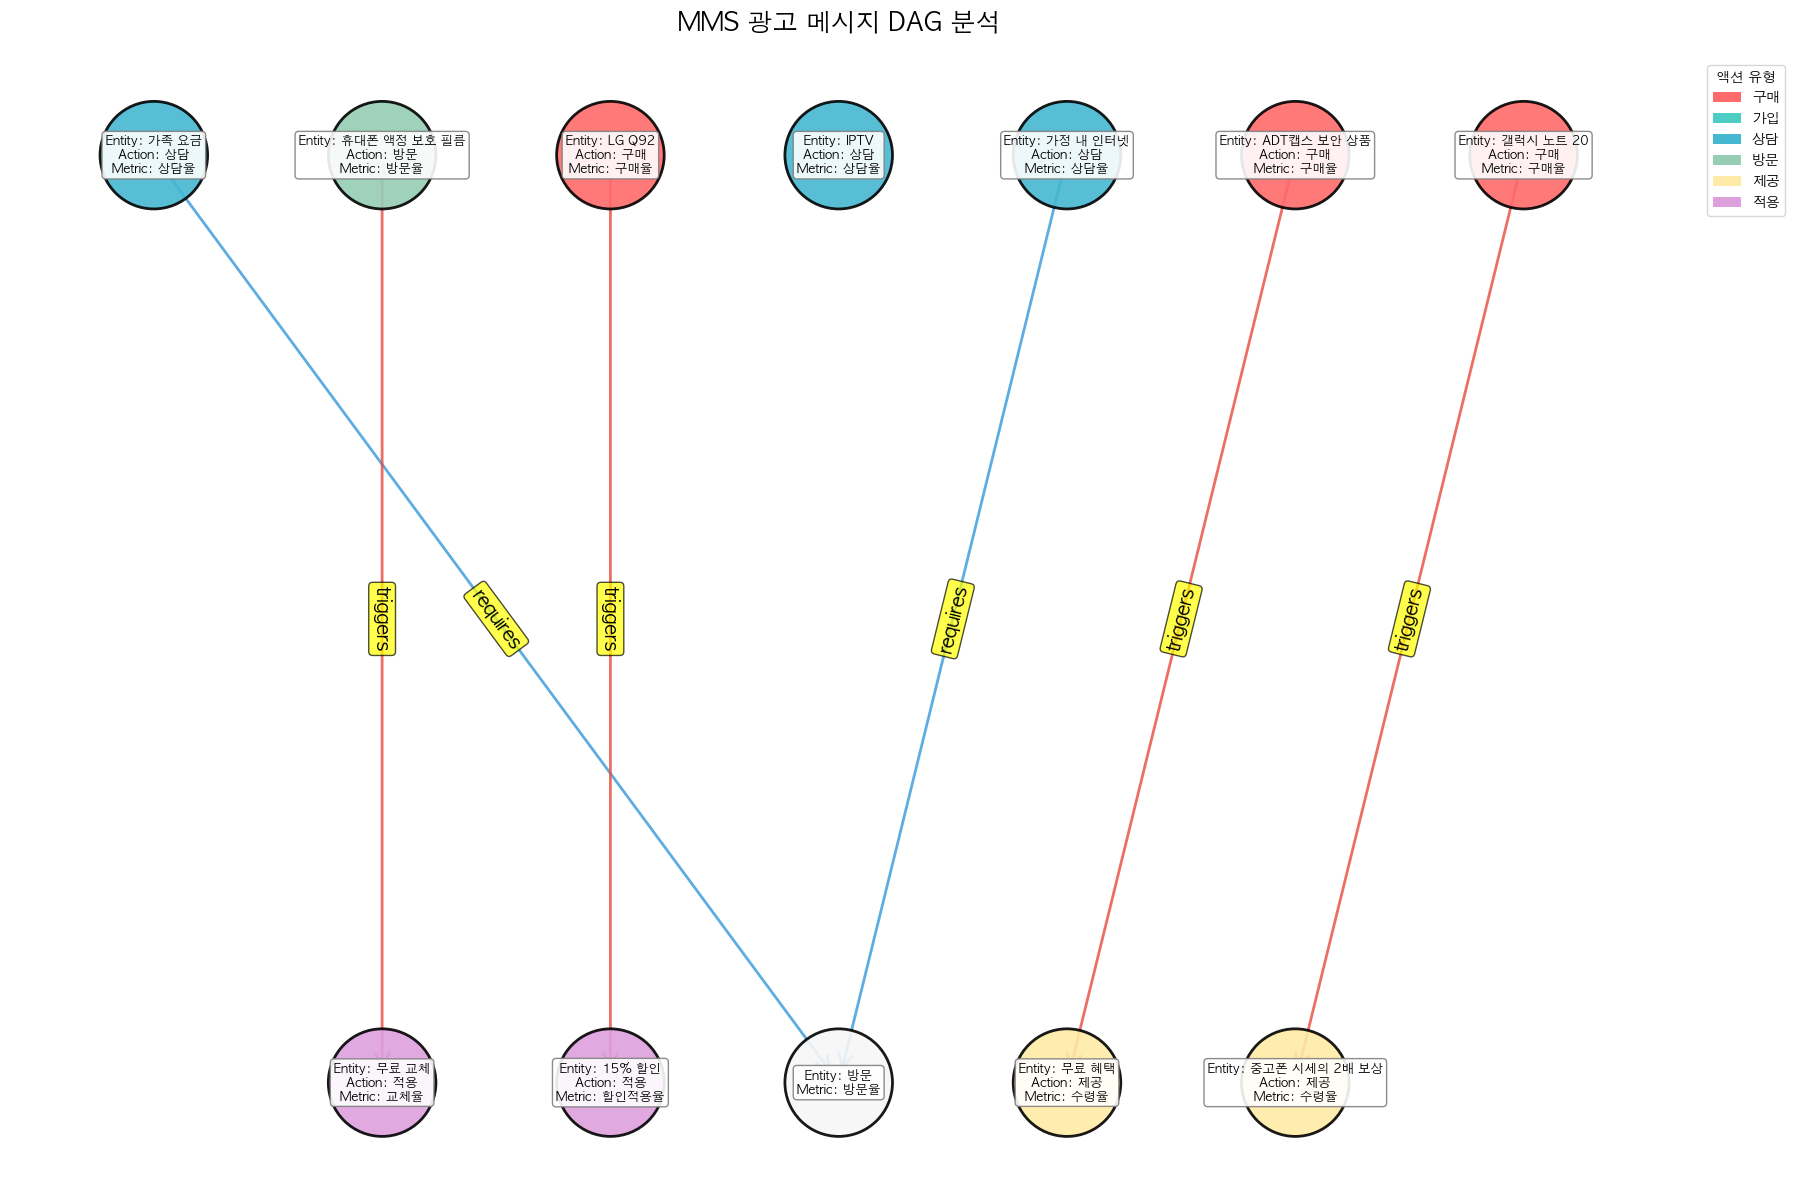

In [42]:
# Cell 27: 개선된 DAG 시각화 (한글 폰트 수정)
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
import numpy as np

def setup_korean_font():
    """한글 폰트 설정"""
    import platform
    import matplotlib.font_manager as fm
    
    # 운영체제별 한글 폰트 설정
    system = platform.system()
    
    if system == 'Darwin':  # macOS
        font_name = 'AppleGothic'
    elif system == 'Windows':  # Windows
        font_name = 'Malgun Gothic'
    else:  # Linux
        font_name = 'DejaVu Sans'
    
    # 폰트 설정
    try:
        plt.rcParams['font.family'] = font_name
        plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
        print(f"한글 폰트를 {font_name}로 설정했습니다.")
    except:
        # 폰트가 없는 경우 대체 방법
        try:
            # 나눔고딕 또는 다른 한글 폰트 찾기
            font_list = [font.name for font in fm.fontManager.ttflist if 'gothic' in font.name.lower() or 'nanum' in font.name.lower()]
            if font_list:
                plt.rcParams['font.family'] = font_list[0]
                print(f"한글 폰트를 {font_list[0]}로 설정했습니다.")
            else:
                print("한글 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.")
                plt.rcParams['font.family'] = 'DejaVu Sans'
        except:
            print("폰트 설정에 실패했습니다. 기본 설정을 사용합니다.")

def create_enhanced_dag_visualization(dag, title="MMS 광고 DAG 분석"):
    """향상된 DAG 시각화"""
    
    # 한글 폰트 설정
    setup_korean_font()
    
    # # 노드 속성 디버깅 출력
    # print("=== 노드 속성 키와 값 ===")
    # for node in dag.nodes():
    #     print(f"노드: {node}")
    #     node_data = dag.nodes[node]
    #     for key, value in node_data.items():
    #         print(f"  {key}: {value}")
    #     print()
    
    # print("=== 에지 속성 키와 값 ===")
    # for u, v, d in dag.edges(data=True):
    #     print(f"에지: {u} -> {v}")
    #     for key, value in d.items():
    #         print(f"  {key}: {value}")
    #     print()
    
    # 계층적 레이아웃 생성
    def hierarchical_layout(G):
        # 위상 정렬
        try:
            topo_order = list(nx.topological_sort(G))
        except:
            # 사이클이 있는 경우 spring layout 사용
            return nx.spring_layout(G, k=3, iterations=100)
        
        # 레벨 계산
        levels = {}
        for node in topo_order:
            if not list(G.predecessors(node)):
                levels[node] = 0
            else:
                levels[node] = max(levels[pred] for pred in G.predecessors(node)) + 1
        
        # 레벨별 그룹화
        level_nodes = defaultdict(list)
        for node, level in levels.items():
            level_nodes[level].append(node)
        
        # 위치 계산 (간격을 절반으로 단축)
        pos = {}
        for level, nodes in level_nodes.items():
            for i, node in enumerate(nodes):
                x = (i - (len(nodes) - 1) / 2) * 0.375  # 수평 간격을 절반으로 (0.75/2)
                y = -level * 0.3  # 수직 간격을 절반으로 (0.6/2)
                pos[node] = (x, y)
        
        return pos
    
    # 노드 색상 매핑 (액션별)
    def get_node_colors(G):
        colors = []
        color_map = {
            '구매': '#FF6B6B',    # 빨간색 계열
            '가입': '#4ECDC4',    # 청록색 계열  
            '상담': '#45B7D1',    # 파란색 계열
            '방문': '#96CEB4',    # 초록색 계열
            '제공': '#FFEAA7',    # 노란색 계열
            '적용': '#DDA0DD',    # 보라색 계열
            '다운로드': '#98D8C8', # 민트색 계열
            '': '#F7F7F7'         # 기본색 (액션 없음)
        }
        
        for node in G.nodes():
            action = G.nodes[node].get('action', '')
            colors.append(color_map.get(action, '#F0F0F0'))
        
        return colors
    
    # 엣지 색상 매핑 (관계별)
    def get_edge_colors(G):
        colors = []
        color_map = {
            'triggers': '#E74C3C',   # 빨간색
            'requires': '#3498DB',   # 파란색
            'bundles_with': '#2ECC71', # 초록색
            'includes': '#F39C12',   # 주황색
            'enables': '#9B59B6',    # 보라색
            'unlocks': '#1ABC9C'     # 청록색
        }
        
        for u, v, d in G.edges(data=True):
            relation = d.get('relation', 'default')
            colors.append(color_map.get(relation, '#7F8C8D'))
        
        return colors
    
    # 레이아웃 계산
    pos = hierarchical_layout(dag)
    
    # 그래프 크기 설정 (속성 정보 표시를 위해 더 크게)
    fig, ax = plt.subplots(figsize=(18, 12))
    
    # 노드 그리기 (크기를 더 크게 증가)
    node_colors = get_node_colors(dag)
    nx.draw_networkx_nodes(dag, pos,
                          node_color=node_colors,
                          node_size=6000,  # 노드 크기를 더 크게 (속성 정보를 위해)
                          alpha=0.9,
                          linewidths=2,
                          edgecolors='black',
                          ax=ax)
    
    # 엣지 그리기
    edge_colors = get_edge_colors(dag)
    nx.draw_networkx_edges(dag, pos,
                          edge_color=edge_colors,
                          arrows=True,
                          arrowsize=25,
                          arrowstyle='->',
                          width=2,
                          alpha=0.8,
                          ax=ax)
    
    # 라벨 그리기 (entity, action, metric 속성만 표시)
    labels = {}
    for node in dag.nodes():
        node_data = dag.nodes[node]
        
        # 특정 속성만 표시
        label_parts = []
        
        # entity 표시
        entity = node_data.get('entity', '')
        if entity:
            label_parts.append(f"Entity: {entity}")
        
        # action 표시
        action = node_data.get('action', '')
        if action:
            label_parts.append(f"Action: {action}")
        
        # metric 표시
        metric = node_data.get('metric', '')
        if metric:
            label_parts.append(f"Metric: {metric}")
        
        # 라벨이 없으면 노드 ID만 표시
        if not label_parts:
            labels[node] = str(node)
        else:
            labels[node] = "\n".join(label_parts)
    
    # 한글 폰트를 명시적으로 지정하여 라벨 그리기 (선택된 속성만 표시)
    nx.draw_networkx_labels(dag, pos, labels,
                           font_size=9,  # 적은 정보로 폰트 크기 다시 증가
                           font_weight='bold',
                           font_family=plt.rcParams['font.family'],  # 명시적 폰트 지정
                           bbox=dict(boxstyle="round,pad=0.3", 
                                   facecolor="white", 
                                   alpha=0.9,
                                   edgecolor='gray'),
                           ax=ax)
    
    # 엣지 라벨 그리기 (폰트 크기 증가)
    edge_labels = {}
    for u, v, d in dag.edges(data=True):
        relation = d.get('relation', '')
        edge_labels[(u, v)] = relation
    
    nx.draw_networkx_edge_labels(dag, pos, edge_labels,
                                font_size=14,  # 엣지 라벨 폰트를 1.5배 증가 (9 * 1.5 = 13.5 → 14)
                                font_family=plt.rcParams['font.family'],  # 명시적 폰트 지정
                                bbox=dict(boxstyle="round,pad=0.2",
                                        facecolor="yellow",
                                        alpha=0.7),
                                ax=ax)
    
    ax.set_title(title, fontsize=18, fontweight='bold', pad=20)  # 제목 폰트 크기 증가
    ax.axis('off')
    
    # 범례 추가
    from matplotlib.patches import Patch
    action_legend = [
        Patch(facecolor='#FF6B6B', label='구매'),
        Patch(facecolor='#4ECDC4', label='가입'),
        Patch(facecolor='#45B7D1', label='상담'),
        Patch(facecolor='#96CEB4', label='방문'),
        Patch(facecolor='#FFEAA7', label='제공'),
        Patch(facecolor='#DDA0DD', label='적용')
    ]
    
    ax.legend(handles=action_legend, 
              title="액션 유형", 
              loc='upper left',
              bbox_to_anchor=(1.02, 1),
              fontsize=10)  # 범례 폰트 크기 증가
    
    plt.tight_layout()
    plt.show()

# 사용 예시:
create_enhanced_dag_visualization(dag, "MMS 광고 메시지 DAG 분석")